In [205]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

#Pickling
from six.moves import cPickle as pickle

%matplotlib inline

In [206]:
from keras.layers import Activation, Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer

from gensim.models import word2vec
from gensim.models import KeyedVectors
from glove import Corpus, Glove

In [207]:
def generate_word2vec_text8(saveTo = 'models/text8.model'):
    sentences = word2vec.Text8Corpus('data/text8')
    model = word2vec.Word2Vec(sentences, size=EMBEDDING_DIM)
    model.save(saveTo)
    model.wv.save_word2vec_format(saveTo + '.bin', binary=True)
    print('DONE! Saved to', saveTo)

def generate_glove_text8(saveTo = 'models/glovetext8.model'):
    import itertools
    sentences = list(itertools.islice(word2vec.Text8Corpus('data/text8'),None))
    corpus = Corpus()
    corpus.fit(sentences, window=10)
    glove = Glove(no_components=EMBEDDING_DIM,learning_rate=0.05)
    glove.fit(corpus.matrix, epochs=30,no_threads=4,verbose=True)
    glove.add_dictionary(corpus.dictionary)
    glove.save(saveTo)
    print('DONE! Saved to', saveTo)
    
def load_data(word_count, emotional_mapping):
    # full = generate_IEMOCAP_df()
    data = pd.read_csv('data/IEMOCAP_sentences.csv',index_col=0)
    data['emotion_code'] = data['emotion'].map( emotional_mapping ).astype(int)
    # Take away fear, surprise,disgust, xxx and others. Not enough data
    data = data[data.emotion_code < 4]
    # Clean Transcripts
    data['text'] = data['text'].apply(clean_text)
    # Filter Word Count
    data = filter_word_count(data, word_count)
#     data,patterns = remove_empty_patterns(data,patterns)
    return data

def clean_text(text):
    punct_str = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~«»“…‘”\t'
    for p in punct_str:
        text = text.replace(p,' ')
    text = re.sub(' +', ' ', text)
    text = re.sub(r"[0-9]+", "", text)
    text = re.sub(".*?\[(.*?)\]","",text) # Take out any [action] text in the transcript
    return text.lower().strip()

def filter_word_count(data, n_count):
    return data[list(map(lambda x: len(x.split(' ')) >= n_count,data['text']))]

def balance_data(data):
    min_sample = min(data.groupby('emotion').count()['emotion_code'])
    emotions_list = list(data['emotion'].unique())
    samples = []
    for emotion in emotions_list:
        samples.append(data[data.emotion == emotion].sample(n=min_sample))
    result = pd.concat(samples).sample(frac=1)
    return result


In [208]:
emotional_mapping = {'ang': 0, 'sad': 1, 'hap': 2, 'neu': 3,'fru': 4,'exc': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
data = load_data(5, emotional_mapping)
# data = balance_data(data)
df = data[['text','emotion_code']]
df.groupby('emotion_code').count()

,text
emotion_code,
0,878
1,782
2,412
3,1209


In [209]:
total = sum(data.groupby('emotion').count()['emotion_code'])
((data.groupby('emotion').count() / total) * 100)['emotion_code']

emotion
ang    26.760134
hap    12.557147
neu    36.848522
sad    23.834197
Name: emotion_code, dtype: float64

In [210]:
# data_balanced = balance_data(data)
# df_balanced = data_balanced[['text','emotion_code']]
# df_balanced.head()
# data_balanced.groupby('emotion').count()

## Parameter

In [211]:
# DATASET
TEST_SIZE      = 0.2

# EMBEDDING
MAX_NUM_WORDS  = 2200 #2954, 2500, 2000, 2700
# MAX_NUM_WORDS  = # 1800, 2000, 2201
EMBEDDING_DIM  = 200
MAX_SEQ_LENGTH = 100
USE_GLOVE      = True

# MODEL
FILTER_SIZES   = [2,3,5]
FEATURE_MAPS   = [10,10,10] #50,100
DROPOUT_RATE   = 0.5

# LEARNING
BATCH_SIZE     = 200
NB_EPOCHS      = 40
RUNS           = 5
VAL_SIZE       = 0.1

## Preprocessing

In [212]:
x_train, x_test, y_train, y_test = train_test_split(data.text, data.emotion_code, test_size=TEST_SIZE)

In [213]:
def max_length(lines):
    return max([len(s.split()) for s in lines])

tokenizer = Tokenizer()#num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

length = max_length(x_train)
word_index = tokenizer.word_index

result = [len(x.split()) for x in x_train]
print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))

print('vocabulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
data   = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

Text informations:
max length: 91 / min length: 5 / mean length: 14 / limit length: 100
vocabulary size: 2263 / limit: 2200


In [214]:
len(data), len(y_train)

(2624, 2624)

# Embeddings

In [215]:
def create_glove_embeddings(data = None, use_text8 = False, LEARNING_RATE=0.05, EPOCHS=30, NO_THREADS=4):
    model = None
    if(use_text8):
        model = Glove.load('models/glovetext8.model')
    else:
        if(data != None):
            corpus = Corpus()
            corpus.fit(data, window=10)
            model = Glove(no_components=EMBEDDING_DIM,learning_rate=LEARNING_RATE)
            model.fit(corpus.matrix, epochs=EPOCHS,no_threads=NO_THREADS,verbose=True)
            model.add_dictionary(corpus.dictionary)
        else:
            print('No data found. Using text8 Corpus')
            model = Glove.load('models/glovetext8.model')
    
    embeddings_index = {}
    for word,index in model.dictionary.items():
        embeddings_index[word] = model.word_vectors[index]
    
    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
    
    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if(embedding_vector is not None):
            embedding_matrix[i] = embedding_vector
    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM,
                     weights=[embedding_matrix], trainable=True)
    
def create_word2vec_embeddings(data = None, use_text8 = False):
    model = None
    if(use_text8):
        model = KeyedVectors.load_word2vec_format('models/text8.model.bin',binary=True)
    else:
        if(data != None):  
            model = word2vec.Word2Vec(data, size=EMBEDDING_DIM)
        else:
            print('No data found. Using text8 Corpus')
            model = KeyedVectors.load_word2vec_format('models/text8.model.bin',binary=True)
    
    embeddings_index = {}
    for word in model.wv.index2word:
        embeddings_index[word] = model[word]
        
    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
    
    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if(embedding_vector is not None):
            embedding_matrix[i] = embedding_vector
    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length = MAX_SEQ_LENGTH,
                    weights= [embedding_matrix], trainable=True)

# Model Definition

## Training

In [201]:
embedding_data = [x.split() for x in x_train]
emb_layers = [create_word2vec_embeddings(use_text8=True),
              create_word2vec_embeddings(embedding_data),
              create_glove_embeddings(use_text8=True),
              create_glove_embeddings(embedding_data)
             ]

emb_layers_names = ['word2vectext8','word2veciemocap','glovetext8','gloveiemocap']

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [202]:
print(len(data),len(y_train))

(2624, 2624)


In [155]:
import cnn_model

histories = []

import time
for i in range(RUNS):
    print('Running iteration %i/%i' % (i+1, RUNS))
    start_time = time.time()
    X_train, X_val, labels, y_val = train_test_split(data, y_train, test_size=VAL_SIZE, random_state=42)

    emb_layer = None
    if USE_GLOVE:
        emb_layer = emb_layers[2] #create_word2vec_embeddings(result)

    model = cnn_model.build_cnn(
        embedding_layer=emb_layer,
        num_words=MAX_NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        filter_sizes=FILTER_SIZES,
        feature_maps=FEATURE_MAPS,
        max_seq_length=MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE
    )

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adadelta(clipvalue=3,lr=0.001),
        metrics=['accuracy']
    )

    history = model.fit(
        X_train, labels,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=(X_val, y_val),
        callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                   verbose=1, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    histories.append(history.history)
    print('Iteration', i+1)
    print("--- %s seconds on ---" % (time.time() - start_time))
    
with open('history/unbalanced_'+emb_layers_names[2]+'_'+str(MAX_NUM_WORDS)+'.pkl', 'wb') as f:
    pickle.dump(histories, f)

Running iteration 1/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 2200
Embedding dim: 200
Filter sizes: [3, 6, 9]
Feature maps: [10, 10, 10]
Max sequence: 100
#############################################
Train on 2361 samples, validate on 263 samples
Epoch 1/40
2361/2361 [==============================] - 4s 2ms/step - loss: 2.2000 - acc: 0.2461 - val_loss: 2.2893 - val_acc: 0.2129

Epoch 00001: val_loss improved from inf to 2.28926, saving model to model-1.h5
Epoch 2/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.1946 - acc: 0.2342 - val_loss: 2.2854 - val_acc: 0.2205

Epoch 00002: val_loss improved from 2.28926 to 2.28540, saving model to model-1.h5
Epoch 3/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.2013 - acc: 0.2346 - val_loss: 2.2816 - val_acc: 0.2167

Epoch 00003: val_loss improved from 2.28540 to 2.28156, saving model to model-1.h5
Epoch 4/40
2361/23

2361/2361 [==============================] - 3s 1ms/step - loss: 1.9959 - acc: 0.2368 - val_loss: 2.1272 - val_acc: 0.2319

Epoch 00037: val_loss improved from 2.13262 to 2.12725, saving model to model-1.h5
Epoch 38/40
2361/2361 [==============================] - 3s 1ms/step - loss: 1.9709 - acc: 0.2397 - val_loss: 2.1219 - val_acc: 0.2319

Epoch 00038: val_loss improved from 2.12725 to 2.12187, saving model to model-1.h5
Epoch 39/40
2361/2361 [==============================] - 3s 1ms/step - loss: 1.9678 - acc: 0.2402 - val_loss: 2.1164 - val_acc: 0.2319

Epoch 00039: val_loss improved from 2.12187 to 2.11643, saving model to model-1.h5
Epoch 40/40
2361/2361 [==============================] - 3s 1ms/step - loss: 1.9647 - acc: 0.2406 - val_loss: 2.1109 - val_acc: 0.2319

Epoch 00040: val_loss improved from 2.11643 to 2.11093, saving model to model-1.h5
('Iteration', 1)
--- 119.468204975 seconds on ---
Running iteration 2/5
Creating CNN 0.0.1
#############################################

2361/2361 [==============================] - 3s 1ms/step - loss: 2.2064 - acc: 0.2351 - val_loss: 2.2679 - val_acc: 0.2281

Epoch 00033: val_loss improved from 2.27294 to 2.26786, saving model to model-2.h5
Epoch 34/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.1859 - acc: 0.2423 - val_loss: 2.2627 - val_acc: 0.2319

Epoch 00034: val_loss improved from 2.26786 to 2.26271, saving model to model-2.h5
Epoch 35/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.1755 - acc: 0.2402 - val_loss: 2.2575 - val_acc: 0.2357

Epoch 00035: val_loss improved from 2.26271 to 2.25754, saving model to model-2.h5
Epoch 36/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.1756 - acc: 0.2355 - val_loss: 2.2524 - val_acc: 0.2395

Epoch 00036: val_loss improved from 2.25754 to 2.25236, saving model to model-2.h5
Epoch 37/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.1662 - acc: 0.2461 - val_loss: 2.2471 - val_acc: 0.2395



2361/2361 [==============================] - 3s 1ms/step - loss: 2.2527 - acc: 0.2469 - val_loss: 2.2528 - val_acc: 0.2586

Epoch 00029: val_loss improved from 2.25733 to 2.25285, saving model to model-3.h5
Epoch 30/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.2475 - acc: 0.2490 - val_loss: 2.2484 - val_acc: 0.2586

Epoch 00030: val_loss improved from 2.25285 to 2.24836, saving model to model-3.h5
Epoch 31/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.2543 - acc: 0.2465 - val_loss: 2.2439 - val_acc: 0.2586

Epoch 00031: val_loss improved from 2.24836 to 2.24386, saving model to model-3.h5
Epoch 32/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.2191 - acc: 0.2520 - val_loss: 2.2393 - val_acc: 0.2586

Epoch 00032: val_loss improved from 2.24386 to 2.23927, saving model to model-3.h5
Epoch 33/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.2357 - acc: 0.2389 - val_loss: 2.2347 - val_acc: 0.2510



2361/2361 [==============================] - 3s 1ms/step - loss: 2.1291 - acc: 0.2435 - val_loss: 2.2203 - val_acc: 0.2471

Epoch 00025: val_loss improved from 2.22528 to 2.22033, saving model to model-4.h5
Epoch 26/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.1419 - acc: 0.2389 - val_loss: 2.2154 - val_acc: 0.2471

Epoch 00026: val_loss improved from 2.22033 to 2.21536, saving model to model-4.h5
Epoch 27/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.1208 - acc: 0.2368 - val_loss: 2.2103 - val_acc: 0.2395

Epoch 00027: val_loss improved from 2.21536 to 2.21034, saving model to model-4.h5
Epoch 28/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.1151 - acc: 0.2380 - val_loss: 2.2053 - val_acc: 0.2395

Epoch 00028: val_loss improved from 2.21034 to 2.20531, saving model to model-4.h5
Epoch 29/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.1243 - acc: 0.2516 - val_loss: 2.2003 - val_acc: 0.2395



2361/2361 [==============================] - 3s 1ms/step - loss: 2.4353 - acc: 0.2363 - val_loss: 2.3979 - val_acc: 0.2776

Epoch 00021: val_loss improved from 2.40336 to 2.39790, saving model to model-5.h5
Epoch 22/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.4181 - acc: 0.2660 - val_loss: 2.3924 - val_acc: 0.2776

Epoch 00022: val_loss improved from 2.39790 to 2.39237, saving model to model-5.h5
Epoch 23/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.4236 - acc: 0.2385 - val_loss: 2.3869 - val_acc: 0.2738

Epoch 00023: val_loss improved from 2.39237 to 2.38685, saving model to model-5.h5
Epoch 24/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.4062 - acc: 0.2435 - val_loss: 2.3814 - val_acc: 0.2776

Epoch 00024: val_loss improved from 2.38685 to 2.38136, saving model to model-5.h5
Epoch 25/40
2361/2361 [==============================] - 3s 1ms/step - loss: 2.4011 - acc: 0.2440 - val_loss: 2.3759 - val_acc: 0.2738



263/263 [==============================] - 0s 307us/step


(array([ 3., 15., 39., 70., 55., 42., 20., 14.,  3.,  2.]),
 array([0.45167357, 0.46947835, 0.48728313, 0.50508792, 0.5228927 ,
        0.54069749, 0.55850227, 0.57630705, 0.59411184, 0.61191662,
        0.6297214 ]),
 <a list of 10 Patch objects>)

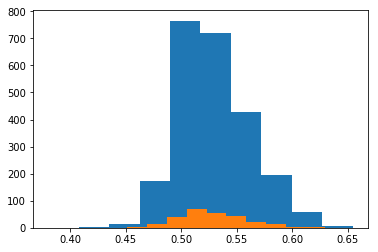

In [167]:
train_predictions = model.predict(X_train, verbose=1)
plt.hist(train_predictions)
test_predictions = model.predict(X_val,verbose=1)
plt.hist(test_predictions)


In [203]:
# BALANCED DATA
printing = {}
MAX_NUM_WORDS_AR = [ 2000, 2200, 1800 ]
WORD_FILTERING = [3,5,7]
emb_layers_names = ['word2vectext8','glovetext8']
for num in MAX_NUM_WORDS_AR:
    for filtering_count in WORD_FILTERING:
        MAX_NUM_WORDS = num
        emotional_mapping = {'ang': 0, 'sad': 1, 'hap': 2, 'neu': 3,'fru': 4,'exc': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
        data = load_data(filtering_count, emotional_mapping)
        df = data[['text','emotion_code']]
        df.head()
        x_train, x_test, y_train, y_test = train_test_split(data.text, data.emotion_code, test_size=TEST_SIZE)
        tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
        tokenizer.fit_on_texts(x_train)
        sequences = tokenizer.texts_to_sequences(x_train)

        length = max_length(x_train)
        word_index = tokenizer.word_index

        result = [len(x.split()) for x in x_train]
        data   = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

        embedding_data = [x.split() for x in x_train]
        emb_layers = [create_word2vec_embeddings(use_text8=True),
    #                   create_word2vec_embeddings(embedding_data),
                      create_glove_embeddings(use_text8=True),
    #                   create_glove_embeddings(embedding_data)
                     ]

    #     ######################################################
        for index,lay in enumerate(emb_layers):

            histories = []

            for i in range(RUNS):
                print('Running iteration %i/%i' % (i+1, RUNS))

                X_train, X_val, labels, y_val = train_test_split(data, y_train, test_size=VAL_SIZE, random_state=42)

                emb_layer = None
                if USE_GLOVE:
                    emb_layer = lay#emb_layers[2] #create_word2vec_embeddings(result)

                model = cnn_model.build_cnn(
                    embedding_layer=emb_layer,
                    num_words=MAX_NUM_WORDS,
                    embedding_dim=EMBEDDING_DIM,
                    filter_sizes=FILTER_SIZES,
                    feature_maps=FEATURE_MAPS,
                    max_seq_length=MAX_SEQ_LENGTH,
                    dropout_rate=DROPOUT_RATE
                )

                model.compile(
                    loss='binary_crossentropy',
                    optimizer=Adadelta(clipvalue=3),
                    metrics=['accuracy']
                )

                history = model.fit(
                    X_train, labels,
                    epochs=NB_EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                               verbose=1, save_best_only=True, mode='min'),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                              ]
                )
                histories.append(history.history)

            with open('history/unbalanced_'+emb_layers_names[index]+'_MAX'+str(MAX_NUM_WORDS)+'_WFILT_'+str(filtering_count)+'.pkl', 'wb') as f:
                pickle.dump(histories, f)
            printing['unbalanced_'+emb_layers_names[index]+'_MAX'+str(MAX_NUM_WORDS)+'_WFILT_'+str(filtering_count)+'.pkl'] = [get_avg(histories, 'loss'),get_avg(histories, 'acc'),get_avg(histories, 'val_loss'),get_avg(histories, 'val_acc')]



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Running iteration 1/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 2000
Embedding dim: 200
Filter sizes: [2, 3, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#############################################
Train on 2782 samples, validate on 310 samples
Epoch 1/40
2782/2782 [==============================] - 10s 4ms/step - loss: -2.4648 - acc: 0.2401 - val_loss: -8.7223 - val_acc: 0.2516

Epoch 00001: val_loss improved from inf to -8.72228, saving model to model-1.h5
Epoch 2/40
2782/2782 [==============================] - 3s 902us/step - loss: -7.5640 - acc: 0.2372 - val_loss: -8.9320 - val_acc: 0.2516

Epoch 00002: val_loss improved from -8.72228 to -8.93195, saving model to model-1.h5
Epoch 3/40
2782/2782 [==============================] - 3s 900us/step - loss: -7.7602 - acc: 0.2372 - val_loss: -9.1199 - val_acc: 0.2516

Epoch 00003: val_loss improved from -8.93195 to -9.11994, saving model to model-1.h5
Ep

2782/2782 [==============================] - 2s 875us/step - loss: -9.1219 - acc: 0.2372 - val_loss: -10.3818 - val_acc: 0.2516

Epoch 00037: val_loss improved from -10.38100 to -10.38177, saving model to model-1.h5
Epoch 38/40
2782/2782 [==============================] - 2s 875us/step - loss: -9.1224 - acc: 0.2372 - val_loss: -10.3823 - val_acc: 0.2516

Epoch 00038: val_loss improved from -10.38177 to -10.38232, saving model to model-1.h5
Epoch 39/40
2782/2782 [==============================] - 2s 866us/step - loss: -9.1227 - acc: 0.2372 - val_loss: -10.3823 - val_acc: 0.2516

Epoch 00039: val_loss improved from -10.38232 to -10.38233, saving model to model-1.h5
Epoch 40/40
2782/2782 [==============================] - 2s 877us/step - loss: -9.1229 - acc: 0.2372 - val_loss: -10.3824 - val_acc: 0.2516

Epoch 00040: val_loss improved from -10.38233 to -10.38239, saving model to model-1.h5
Running iteration 2/5
Creating CNN 0.0.1
#############################################
Embedding:   


Epoch 00032: val_loss did not improve from -10.38064
Epoch 33/40
2782/2782 [==============================] - 2s 863us/step - loss: -9.1194 - acc: 0.2372 - val_loss: -10.3790 - val_acc: 0.2516

Epoch 00033: val_loss did not improve from -10.38064
Epoch 34/40
2782/2782 [==============================] - 2s 866us/step - loss: -9.1195 - acc: 0.2372 - val_loss: -10.3791 - val_acc: 0.2516

Epoch 00034: val_loss did not improve from -10.38064
Epoch 35/40
2782/2782 [==============================] - 2s 869us/step - loss: -9.1197 - acc: 0.2372 - val_loss: -10.3793 - val_acc: 0.2516

Epoch 00035: val_loss did not improve from -10.38064
Epoch 36/40
2782/2782 [==============================] - 2s 863us/step - loss: -9.1199 - acc: 0.2372 - val_loss: -10.3796 - val_acc: 0.2516

Epoch 00036: val_loss did not improve from -10.38064
Epoch 37/40
2782/2782 [==============================] - 2s 867us/step - loss: -9.1201 - acc: 0.2372 - val_loss: -10.3796 - val_acc: 0.2516

Epoch 00037: val_loss did not

2782/2782 [==============================] - 2s 868us/step - loss: -9.1087 - acc: 0.2372 - val_loss: -10.3682 - val_acc: 0.2516

Epoch 00030: val_loss improved from -10.36811 to -10.36824, saving model to model-3.h5
Epoch 31/40
2782/2782 [==============================] - 2s 867us/step - loss: -9.1088 - acc: 0.2372 - val_loss: -10.3684 - val_acc: 0.2516

Epoch 00031: val_loss improved from -10.36824 to -10.36840, saving model to model-3.h5
Epoch 32/40
2782/2782 [==============================] - 2s 863us/step - loss: -9.1090 - acc: 0.2372 - val_loss: -10.3686 - val_acc: 0.2516

Epoch 00032: val_loss improved from -10.36840 to -10.36858, saving model to model-3.h5
Epoch 33/40
2782/2782 [==============================] - 2s 864us/step - loss: -9.1092 - acc: 0.2372 - val_loss: -10.3688 - val_acc: 0.2516

Epoch 00033: val_loss improved from -10.36858 to -10.36878, saving model to model-3.h5
Epoch 34/40
2782/2782 [==============================] - 2s 874us/step - loss: -9.1094 - acc: 0.2372

2782/2782 [==============================] - 2s 854us/step - loss: -9.1107 - acc: 0.2372 - val_loss: -10.3733 - val_acc: 0.2516

Epoch 00025: val_loss improved from -10.36768 to -10.37335, saving model to model-4.h5
Epoch 26/40
2782/2782 [==============================] - 2s 849us/step - loss: -9.1137 - acc: 0.2372 - val_loss: -10.3758 - val_acc: 0.2516

Epoch 00026: val_loss improved from -10.37335 to -10.37579, saving model to model-4.h5
Epoch 27/40
2782/2782 [==============================] - 2s 858us/step - loss: -9.1166 - acc: 0.2372 - val_loss: -10.3769 - val_acc: 0.2516

Epoch 00027: val_loss improved from -10.37579 to -10.37692, saving model to model-4.h5
Epoch 28/40
2782/2782 [==============================] - 2s 854us/step - loss: -9.1192 - acc: 0.2372 - val_loss: -10.3778 - val_acc: 0.2516

Epoch 00028: val_loss improved from -10.37692 to -10.37782, saving model to model-4.h5
Epoch 29/40
2782/2782 [==============================] - 2s 853us/step - loss: -9.1205 - acc: 0.2372

2782/2782 [==============================] - 2s 866us/step - loss: -9.1056 - acc: 0.2372 - val_loss: -10.3678 - val_acc: 0.2516

Epoch 00016: val_loss improved from -10.36269 to -10.36775, saving model to model-1.h5
Epoch 17/40
2782/2782 [==============================] - 2s 853us/step - loss: -9.1100 - acc: 0.2372 - val_loss: -10.3719 - val_acc: 0.2516

Epoch 00017: val_loss improved from -10.36775 to -10.37187, saving model to model-1.h5
Epoch 18/40
2782/2782 [==============================] - 2s 860us/step - loss: -9.1121 - acc: 0.2372 - val_loss: -10.3734 - val_acc: 0.2516

Epoch 00018: val_loss improved from -10.37187 to -10.37342, saving model to model-1.h5
Epoch 19/40
2782/2782 [==============================] - 2s 856us/step - loss: -9.1133 - acc: 0.2372 - val_loss: -10.3705 - val_acc: 0.2516

Epoch 00019: val_loss did not improve from -10.37342
Epoch 20/40
2782/2782 [==============================] - 2s 863us/step - loss: -9.1117 - acc: 0.2372 - val_loss: -10.3720 - val_acc: 0


Epoch 00012: val_loss improved from -10.23535 to -10.26342, saving model to model-2.h5
Epoch 13/40
2782/2782 [==============================] - 2s 852us/step - loss: -9.0197 - acc: 0.2372 - val_loss: -10.2963 - val_acc: 0.2516

Epoch 00013: val_loss improved from -10.26342 to -10.29631, saving model to model-2.h5
Epoch 14/40
2782/2782 [==============================] - 2s 856us/step - loss: -9.0456 - acc: 0.2372 - val_loss: -10.3171 - val_acc: 0.2516

Epoch 00014: val_loss improved from -10.29631 to -10.31706, saving model to model-2.h5
Epoch 15/40
2782/2782 [==============================] - 2s 853us/step - loss: -9.0646 - acc: 0.2372 - val_loss: -10.3327 - val_acc: 0.2516

Epoch 00015: val_loss improved from -10.31706 to -10.33267, saving model to model-2.h5
Epoch 16/40
2782/2782 [==============================] - 2s 851us/step - loss: -9.0794 - acc: 0.2372 - val_loss: -10.3472 - val_acc: 0.2516

Epoch 00016: val_loss improved from -10.33267 to -10.34722, saving model to model-2.h5


2782/2782 [==============================] - 2s 863us/step - loss: -8.7974 - acc: 0.2372 - val_loss: -10.1038 - val_acc: 0.2516

Epoch 00010: val_loss improved from -10.01310 to -10.10383, saving model to model-3.h5
Epoch 11/40
2782/2782 [==============================] - 2s 861us/step - loss: -8.8780 - acc: 0.2372 - val_loss: -10.1579 - val_acc: 0.2516

Epoch 00011: val_loss improved from -10.10383 to -10.15787, saving model to model-3.h5
Epoch 12/40
2782/2782 [==============================] - 2s 865us/step - loss: -8.9122 - acc: 0.2372 - val_loss: -10.1873 - val_acc: 0.2516

Epoch 00012: val_loss improved from -10.15787 to -10.18731, saving model to model-3.h5
Epoch 13/40
2782/2782 [==============================] - 2s 863us/step - loss: -8.9406 - acc: 0.2372 - val_loss: -10.2149 - val_acc: 0.2516

Epoch 00013: val_loss improved from -10.18731 to -10.21489, saving model to model-3.h5
Epoch 14/40
2782/2782 [==============================] - 2s 860us/step - loss: -8.9677 - acc: 0.2372


Epoch 00002: val_loss improved from -8.86518 to -9.07807, saving model to model-5.h5
Epoch 3/40
2782/2782 [==============================] - 2s 857us/step - loss: -7.9092 - acc: 0.2372 - val_loss: -9.2608 - val_acc: 0.2516

Epoch 00003: val_loss improved from -9.07807 to -9.26078, saving model to model-5.h5
Epoch 4/40
2782/2782 [==============================] - 2s 855us/step - loss: -8.0791 - acc: 0.2372 - val_loss: -9.4229 - val_acc: 0.2516

Epoch 00004: val_loss improved from -9.26078 to -9.42293, saving model to model-5.h5
Epoch 5/40
2782/2782 [==============================] - 2s 859us/step - loss: -8.2302 - acc: 0.2372 - val_loss: -9.5677 - val_acc: 0.2516

Epoch 00005: val_loss improved from -9.42293 to -9.56772, saving model to model-5.h5
Epoch 6/40
2782/2782 [==============================] - 3s 921us/step - loss: -8.3688 - acc: 0.2372 - val_loss: -9.6990 - val_acc: 0.2516

Epoch 00006: val_loss improved from -9.56772 to -9.69900, saving model to model-5.h5
Epoch 7/40
2782/27

2782/2782 [==============================] - 2s 867us/step - loss: -9.1231 - acc: 0.2372 - val_loss: -10.3852 - val_acc: 0.2516

Epoch 00040: val_loss improved from -10.38349 to -10.38523, saving model to model-5.h5
Running iteration 1/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 2000
Embedding dim: 200
Filter sizes: [2, 3, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#############################################
Train on 2361 samples, validate on 263 samples
Epoch 1/40
2361/2361 [==============================] - 10s 4ms/step - loss: -2.2465 - acc: 0.2474 - val_loss: -7.9127 - val_acc: 0.2319

Epoch 00001: val_loss improved from inf to -7.91271, saving model to model-1.h5
Epoch 2/40
2361/2361 [==============================] - 2s 872us/step - loss: -7.7696 - acc: 0.2435 - val_loss: -8.1605 - val_acc: 0.2319

Epoch 00002: val_loss improved from -7.91271 to -8.16046, saving model to model-1.h5
Epoch 3/40

2361/2361 [==============================] - 2s 864us/step - loss: -9.3829 - acc: 0.2435 - val_loss: -9.6891 - val_acc: 0.2319

Epoch 00037: val_loss did not improve from -9.69013
Epoch 38/40
2361/2361 [==============================] - 2s 867us/step - loss: -9.3830 - acc: 0.2435 - val_loss: -9.6892 - val_acc: 0.2319

Epoch 00038: val_loss did not improve from -9.69013
Epoch 39/40
2361/2361 [==============================] - 2s 863us/step - loss: -9.3830 - acc: 0.2435 - val_loss: -9.6893 - val_acc: 0.2319

Epoch 00039: val_loss did not improve from -9.69013
Epoch 40/40
2361/2361 [==============================] - 2s 874us/step - loss: -9.3831 - acc: 0.2435 - val_loss: -9.6894 - val_acc: 0.2319

Epoch 00040: val_loss did not improve from -9.69013
Running iteration 2/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 2000
Embedding dim: 200
Filter sizes: [2, 3, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#####

2361/2361 [==============================] - 2s 858us/step - loss: -9.3760 - acc: 0.2435 - val_loss: -9.6831 - val_acc: 0.2319

Epoch 00029: val_loss improved from -9.68151 to -9.68313, saving model to model-3.h5
Epoch 30/40
2361/2361 [==============================] - 2s 853us/step - loss: -9.3777 - acc: 0.2435 - val_loss: -9.6849 - val_acc: 0.2319

Epoch 00030: val_loss improved from -9.68313 to -9.68494, saving model to model-3.h5
Epoch 31/40
2361/2361 [==============================] - 2s 865us/step - loss: -9.3796 - acc: 0.2435 - val_loss: -9.6869 - val_acc: 0.2319

Epoch 00031: val_loss improved from -9.68494 to -9.68695, saving model to model-3.h5
Epoch 32/40
2361/2361 [==============================] - 2s 856us/step - loss: -9.3797 - acc: 0.2435 - val_loss: -9.6843 - val_acc: 0.2319

Epoch 00032: val_loss did not improve from -9.68695
Epoch 33/40
2361/2361 [==============================] - 2s 858us/step - loss: -9.3790 - acc: 0.2435 - val_loss: -9.6862 - val_acc: 0.2319

Epoch

2361/2361 [==============================] - 2s 867us/step - loss: -9.3090 - acc: 0.2435 - val_loss: -9.6171 - val_acc: 0.2319

Epoch 00022: val_loss improved from -9.61623 to -9.61713, saving model to model-5.h5
Epoch 23/40
2361/2361 [==============================] - 2s 864us/step - loss: -9.3126 - acc: 0.2435 - val_loss: -9.6209 - val_acc: 0.2319

Epoch 00023: val_loss improved from -9.61713 to -9.62087, saving model to model-5.h5
Epoch 24/40
2361/2361 [==============================] - 2s 864us/step - loss: -9.3165 - acc: 0.2435 - val_loss: -9.6251 - val_acc: 0.2319

Epoch 00024: val_loss improved from -9.62087 to -9.62509, saving model to model-5.h5
Epoch 25/40
2361/2361 [==============================] - 2s 860us/step - loss: -9.3210 - acc: 0.2435 - val_loss: -9.6300 - val_acc: 0.2319

Epoch 00025: val_loss improved from -9.62509 to -9.62996, saving model to model-5.h5
Epoch 26/40
2361/2361 [==============================] - 2s 865us/step - loss: -9.3262 - acc: 0.2435 - val_loss:

2361/2361 [==============================] - 2s 877us/step - loss: -9.2559 - acc: 0.2435 - val_loss: -9.5799 - val_acc: 0.2319

Epoch 00014: val_loss improved from -9.54400 to -9.57990, saving model to model-2.h5
Epoch 15/40
2361/2361 [==============================] - 2s 861us/step - loss: -9.2878 - acc: 0.2435 - val_loss: -9.6055 - val_acc: 0.2319

Epoch 00015: val_loss improved from -9.57990 to -9.60549, saving model to model-2.h5
Epoch 16/40
2361/2361 [==============================] - 2s 865us/step - loss: -9.3093 - acc: 0.2435 - val_loss: -9.6267 - val_acc: 0.2319

Epoch 00016: val_loss improved from -9.60549 to -9.62667, saving model to model-2.h5
Epoch 17/40
2361/2361 [==============================] - 2s 862us/step - loss: -9.3291 - acc: 0.2435 - val_loss: -9.6434 - val_acc: 0.2319

Epoch 00017: val_loss improved from -9.62667 to -9.64336, saving model to model-2.h5
Epoch 18/40
2361/2361 [==============================] - 2s 861us/step - loss: -9.3416 - acc: 0.2435 - val_loss:

2361/2361 [==============================] - 2s 854us/step - loss: -8.4885 - acc: 0.2435 - val_loss: -8.8638 - val_acc: 0.2319

Epoch 00006: val_loss improved from -8.73880 to -8.86375, saving model to model-4.h5
Epoch 7/40
2361/2361 [==============================] - 2s 853us/step - loss: -8.6053 - acc: 0.2435 - val_loss: -8.9731 - val_acc: 0.2319

Epoch 00007: val_loss improved from -8.86375 to -8.97310, saving model to model-4.h5
Epoch 8/40
2361/2361 [==============================] - 2s 853us/step - loss: -8.7167 - acc: 0.2435 - val_loss: -9.0859 - val_acc: 0.2319

Epoch 00008: val_loss improved from -8.97310 to -9.08589, saving model to model-4.h5
Epoch 9/40
2361/2361 [==============================] - 2s 856us/step - loss: -8.8196 - acc: 0.2435 - val_loss: -9.1929 - val_acc: 0.2319

Epoch 00009: val_loss improved from -9.08589 to -9.19289, saving model to model-4.h5
Epoch 10/40
2361/2361 [==============================] - 2s 858us/step - loss: -8.9136 - acc: 0.2435 - val_loss: -9

Epoch 2/40
2361/2361 [==============================] - 2s 853us/step - loss: -7.8542 - acc: 0.2435 - val_loss: -8.2579 - val_acc: 0.2319

Epoch 00002: val_loss improved from -8.08832 to -8.25795, saving model to model-5.h5
Epoch 3/40
2361/2361 [==============================] - 2s 856us/step - loss: -8.0175 - acc: 0.2435 - val_loss: -8.4109 - val_acc: 0.2319

Epoch 00003: val_loss improved from -8.25795 to -8.41094, saving model to model-5.h5
Epoch 4/40
2361/2361 [==============================] - 2s 849us/step - loss: -8.1684 - acc: 0.2435 - val_loss: -8.5593 - val_acc: 0.2319

Epoch 00004: val_loss improved from -8.41094 to -8.55930, saving model to model-5.h5
Epoch 5/40
2361/2361 [==============================] - 2s 856us/step - loss: -8.3114 - acc: 0.2435 - val_loss: -8.6996 - val_acc: 0.2319

Epoch 00005: val_loss improved from -8.55930 to -8.69961, saving model to model-5.h5
Epoch 6/40
2361/2361 [==============================] - 2s 849us/step - loss: -8.4465 - acc: 0.2435 - va

2361/2361 [==============================] - 2s 857us/step - loss: -9.3775 - acc: 0.2435 - val_loss: -9.6847 - val_acc: 0.2319

Epoch 00039: val_loss did not improve from -9.68520
Epoch 40/40
2361/2361 [==============================] - 2s 852us/step - loss: -9.3793 - acc: 0.2435 - val_loss: -9.6865 - val_acc: 0.2319

Epoch 00040: val_loss improved from -9.68520 to -9.68653, saving model to model-5.h5
Running iteration 1/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 2000
Embedding dim: 200
Filter sizes: [2, 3, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#############################################
Train on 1913 samples, validate on 213 samples
Epoch 1/40
1913/1913 [==============================] - 11s 6ms/step - loss: -0.1353 - acc: 0.2467 - val_loss: -5.4936 - val_acc: 0.2676

Epoch 00001: val_loss improved from inf to -5.49359, saving model to model-1.h5
Epoch 2/40
1913/1913 [=======================


Epoch 00034: val_loss improved from -8.37081 to -8.37221, saving model to model-1.h5
Epoch 35/40
1913/1913 [==============================] - 2s 851us/step - loss: -9.2323 - acc: 0.2368 - val_loss: -8.3704 - val_acc: 0.2676

Epoch 00035: val_loss did not improve from -8.37221
Epoch 36/40
1913/1913 [==============================] - 2s 851us/step - loss: -9.2308 - acc: 0.2368 - val_loss: -8.3731 - val_acc: 0.2676

Epoch 00036: val_loss improved from -8.37221 to -8.37310, saving model to model-1.h5
Epoch 37/40
1913/1913 [==============================] - 2s 866us/step - loss: -9.2330 - acc: 0.2368 - val_loss: -8.3737 - val_acc: 0.2676

Epoch 00037: val_loss improved from -8.37310 to -8.37367, saving model to model-1.h5
Epoch 38/40
1913/1913 [==============================] - 2s 854us/step - loss: -9.2340 - acc: 0.2368 - val_loss: -8.3893 - val_acc: 0.2676

Epoch 00038: val_loss improved from -8.37367 to -8.38926, saving model to model-1.h5
Epoch 39/40
1913/1913 [========================

1913/1913 [==============================] - 2s 853us/step - loss: -9.2080 - acc: 0.2368 - val_loss: -8.3510 - val_acc: 0.2676

Epoch 00027: val_loss improved from -8.34699 to -8.35099, saving model to model-3.h5
Epoch 28/40
1913/1913 [==============================] - 2s 862us/step - loss: -9.2119 - acc: 0.2368 - val_loss: -8.3548 - val_acc: 0.2676

Epoch 00028: val_loss improved from -8.35099 to -8.35484, saving model to model-3.h5
Epoch 29/40
1913/1913 [==============================] - 2s 862us/step - loss: -9.2157 - acc: 0.2368 - val_loss: -8.3586 - val_acc: 0.2676

Epoch 00029: val_loss improved from -8.35484 to -8.35858, saving model to model-3.h5
Epoch 30/40
1913/1913 [==============================] - 2s 853us/step - loss: -9.2194 - acc: 0.2368 - val_loss: -8.3623 - val_acc: 0.2676

Epoch 00030: val_loss improved from -8.35858 to -8.36226, saving model to model-3.h5
Epoch 31/40
1913/1913 [==============================] - 2s 854us/step - loss: -9.2226 - acc: 0.2368 - val_loss:

1913/1913 [==============================] - 2s 857us/step - loss: -9.1628 - acc: 0.2368 - val_loss: -8.3115 - val_acc: 0.2676

Epoch 00023: val_loss improved from -8.29742 to -8.31152, saving model to model-4.h5
Epoch 24/40
1913/1913 [==============================] - 2s 857us/step - loss: -9.1751 - acc: 0.2368 - val_loss: -8.3216 - val_acc: 0.2676

Epoch 00024: val_loss improved from -8.31152 to -8.32159, saving model to model-4.h5
Epoch 25/40
1913/1913 [==============================] - 2s 870us/step - loss: -9.1858 - acc: 0.2368 - val_loss: -8.3323 - val_acc: 0.2676

Epoch 00025: val_loss improved from -8.32159 to -8.33232, saving model to model-4.h5
Epoch 26/40
1913/1913 [==============================] - 2s 858us/step - loss: -9.1938 - acc: 0.2368 - val_loss: -8.3403 - val_acc: 0.2676

Epoch 00026: val_loss improved from -8.33232 to -8.34032, saving model to model-4.h5
Epoch 27/40
1913/1913 [==============================] - 2s 857us/step - loss: -9.2011 - acc: 0.2368 - val_loss:


Epoch 00018: val_loss improved from -8.18734 to -8.23336, saving model to model-5.h5
Epoch 19/40
1913/1913 [==============================] - 2s 863us/step - loss: -9.1022 - acc: 0.2368 - val_loss: -8.2592 - val_acc: 0.2676

Epoch 00019: val_loss improved from -8.23336 to -8.25923, saving model to model-5.h5
Epoch 20/40
1913/1913 [==============================] - 2s 864us/step - loss: -9.1311 - acc: 0.2368 - val_loss: -8.2875 - val_acc: 0.2676

Epoch 00020: val_loss improved from -8.25923 to -8.28752, saving model to model-5.h5
Epoch 21/40
1913/1913 [==============================] - 2s 867us/step - loss: -9.1564 - acc: 0.2368 - val_loss: -8.3083 - val_acc: 0.2676

Epoch 00021: val_loss improved from -8.28752 to -8.30831, saving model to model-5.h5
Epoch 22/40
1913/1913 [==============================] - 2s 865us/step - loss: -9.1723 - acc: 0.2368 - val_loss: -8.3185 - val_acc: 0.2676

Epoch 00022: val_loss improved from -8.30831 to -8.31847, saving model to model-5.h5
Epoch 23/40
19

1913/1913 [==============================] - 2s 871us/step - loss: -9.1087 - acc: 0.2368 - val_loss: -8.2667 - val_acc: 0.2676

Epoch 00015: val_loss improved from -8.23596 to -8.26671, saving model to model-1.h5
Epoch 16/40
1913/1913 [==============================] - 2s 873us/step - loss: -9.1347 - acc: 0.2368 - val_loss: -8.2870 - val_acc: 0.2676

Epoch 00016: val_loss improved from -8.26671 to -8.28699, saving model to model-1.h5
Epoch 17/40
1913/1913 [==============================] - 2s 871us/step - loss: -9.1543 - acc: 0.2368 - val_loss: -8.3057 - val_acc: 0.2676

Epoch 00017: val_loss improved from -8.28699 to -8.30570, saving model to model-1.h5
Epoch 18/40
1913/1913 [==============================] - 2s 872us/step - loss: -9.1712 - acc: 0.2368 - val_loss: -8.3207 - val_acc: 0.2676

Epoch 00018: val_loss improved from -8.30570 to -8.32070, saving model to model-1.h5
Epoch 19/40
1913/1913 [==============================] - 2s 870us/step - loss: -9.1856 - acc: 0.2368 - val_loss:

1913/1913 [==============================] - 2s 1ms/step - loss: -8.5164 - acc: 0.2368 - val_loss: -7.7138 - val_acc: 0.2676

Epoch 00008: val_loss improved from -7.61299 to -7.71381, saving model to model-3.h5
Epoch 9/40
1913/1913 [==============================] - 2s 1ms/step - loss: -8.6141 - acc: 0.2368 - val_loss: -7.8070 - val_acc: 0.2676

Epoch 00009: val_loss improved from -7.71381 to -7.80696, saving model to model-3.h5
Epoch 10/40
1913/1913 [==============================] - 2s 1ms/step - loss: -8.7054 - acc: 0.2368 - val_loss: -7.8912 - val_acc: 0.2676

Epoch 00010: val_loss improved from -7.80696 to -7.89118, saving model to model-3.h5
Epoch 11/40
1913/1913 [==============================] - 2s 1ms/step - loss: -8.7858 - acc: 0.2368 - val_loss: -7.9687 - val_acc: 0.2676

Epoch 00011: val_loss improved from -7.89118 to -7.96868, saving model to model-3.h5
Epoch 12/40
1913/1913 [==============================] - 2s 1ms/step - loss: -8.8595 - acc: 0.2368 - val_loss: -8.0417 - 

1913/1913 [==============================] - 2s 1ms/step - loss: -8.0153 - acc: 0.2368 - val_loss: -7.2365 - val_acc: 0.2676

Epoch 00004: val_loss improved from -7.09307 to -7.23651, saving model to model-4.h5
Epoch 5/40
1913/1913 [==============================] - 2s 1ms/step - loss: -8.1516 - acc: 0.2368 - val_loss: -7.3639 - val_acc: 0.2676

Epoch 00005: val_loss improved from -7.23651 to -7.36391, saving model to model-4.h5
Epoch 6/40
1913/1913 [==============================] - 2s 1ms/step - loss: -8.2733 - acc: 0.2368 - val_loss: -7.4799 - val_acc: 0.2676

Epoch 00006: val_loss improved from -7.36391 to -7.47994, saving model to model-4.h5
Epoch 7/40
1913/1913 [==============================] - 2s 1ms/step - loss: -8.3861 - acc: 0.2368 - val_loss: -7.5882 - val_acc: 0.2676

Epoch 00007: val_loss improved from -7.47994 to -7.58823, saving model to model-4.h5
Epoch 8/40
1913/1913 [==============================] - 2s 1ms/step - loss: -8.4896 - acc: 0.2368 - val_loss: -7.6868 - val

Train on 1913 samples, validate on 213 samples
Epoch 1/40
1913/1913 [==============================] - 12s 6ms/step - loss: -3.6758 - acc: 0.2410 - val_loss: -6.7645 - val_acc: 0.2676

Epoch 00001: val_loss improved from inf to -6.76454, saving model to model-5.h5
Epoch 2/40
1913/1913 [==============================] - 2s 1ms/step - loss: -7.6941 - acc: 0.2368 - val_loss: -6.9241 - val_acc: 0.2676

Epoch 00002: val_loss improved from -6.76454 to -6.92414, saving model to model-5.h5
Epoch 3/40
1913/1913 [==============================] - 2s 1ms/step - loss: -7.8459 - acc: 0.2368 - val_loss: -7.0664 - val_acc: 0.2676

Epoch 00003: val_loss improved from -6.92414 to -7.06638, saving model to model-5.h5
Epoch 4/40
1913/1913 [==============================] - 2s 1ms/step - loss: -7.9814 - acc: 0.2368 - val_loss: -7.1932 - val_acc: 0.2676

Epoch 00004: val_loss improved from -7.06638 to -7.19324, saving model to model-5.h5
Epoch 5/40
1913/1913 [==============================] - 2s 1ms/step -

1913/1913 [==============================] - 2s 1ms/step - loss: -9.2205 - acc: 0.2368 - val_loss: -8.3618 - val_acc: 0.2676

Epoch 00038: val_loss did not improve from -8.36352
Epoch 39/40
1913/1913 [==============================] - 2s 1ms/step - loss: -9.2215 - acc: 0.2368 - val_loss: -8.3628 - val_acc: 0.2676

Epoch 00039: val_loss did not improve from -8.36352
Epoch 40/40
1913/1913 [==============================] - 2s 1ms/step - loss: -9.2225 - acc: 0.2368 - val_loss: -8.3639 - val_acc: 0.2676

Epoch 00040: val_loss improved from -8.36352 to -8.36390, saving model to model-5.h5
Running iteration 1/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 2200
Embedding dim: 200
Filter sizes: [2, 3, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#############################################
Train on 2782 samples, validate on 310 samples
Epoch 1/40
2782/2782 [==============================] - 14s 5ms/step - loss: 

2782/2782 [==============================] - 2s 870us/step - loss: -9.8631 - acc: 0.2383 - val_loss: -7.7549 - val_acc: 0.2548

Epoch 00031: val_loss did not improve from -7.75723
Epoch 32/40
2782/2782 [==============================] - 2s 868us/step - loss: -9.8631 - acc: 0.2383 - val_loss: -7.7549 - val_acc: 0.2548

Epoch 00032: val_loss did not improve from -7.75723
Epoch 33/40
2782/2782 [==============================] - 2s 869us/step - loss: -9.8632 - acc: 0.2383 - val_loss: -7.7550 - val_acc: 0.2548

Epoch 00033: val_loss did not improve from -7.75723
Epoch 34/40
2782/2782 [==============================] - 2s 870us/step - loss: -9.8633 - acc: 0.2383 - val_loss: -7.7551 - val_acc: 0.2548

Epoch 00034: val_loss did not improve from -7.75723
Epoch 35/40
2782/2782 [==============================] - 2s 862us/step - loss: -9.8634 - acc: 0.2383 - val_loss: -7.7552 - val_acc: 0.2548

Epoch 00035: val_loss did not improve from -7.75723
Epoch 36/40
2782/2782 [=============================


Epoch 00027: val_loss improved from -7.75447 to -7.75551, saving model to model-3.h5
Epoch 28/40
2782/2782 [==============================] - 2s 861us/step - loss: -9.8641 - acc: 0.2383 - val_loss: -7.7567 - val_acc: 0.2548

Epoch 00028: val_loss improved from -7.75551 to -7.75669, saving model to model-3.h5
Epoch 29/40
2782/2782 [==============================] - 2s 864us/step - loss: -9.8652 - acc: 0.2383 - val_loss: -7.7579 - val_acc: 0.2548

Epoch 00029: val_loss improved from -7.75669 to -7.75787, saving model to model-3.h5
Epoch 30/40
2782/2782 [==============================] - 2s 865us/step - loss: -9.8410 - acc: 0.2383 - val_loss: -7.7547 - val_acc: 0.2548

Epoch 00030: val_loss did not improve from -7.75787
Epoch 31/40
2782/2782 [==============================] - 2s 861us/step - loss: -9.8631 - acc: 0.2383 - val_loss: -7.7550 - val_acc: 0.2548

Epoch 00031: val_loss did not improve from -7.75787
Epoch 32/40
2782/2782 [==============================] - 2s 864us/step - loss: -

2782/2782 [==============================] - 2s 863us/step - loss: -9.8180 - acc: 0.2383 - val_loss: -7.7125 - val_acc: 0.2548

Epoch 00020: val_loss improved from -7.70751 to -7.71252, saving model to model-5.h5
Epoch 21/40
2782/2782 [==============================] - 2s 855us/step - loss: -9.8234 - acc: 0.2383 - val_loss: -7.7184 - val_acc: 0.2548

Epoch 00021: val_loss improved from -7.71252 to -7.71842, saving model to model-5.h5
Epoch 22/40
2782/2782 [==============================] - 2s 859us/step - loss: -9.8297 - acc: 0.2383 - val_loss: -7.7252 - val_acc: 0.2548

Epoch 00022: val_loss improved from -7.71842 to -7.72525, saving model to model-5.h5
Epoch 23/40
2782/2782 [==============================] - 2s 859us/step - loss: -9.8369 - acc: 0.2383 - val_loss: -7.7328 - val_acc: 0.2548

Epoch 00023: val_loss improved from -7.72525 to -7.73283, saving model to model-5.h5
Epoch 24/40
2782/2782 [==============================] - 2s 854us/step - loss: -9.8434 - acc: 0.2383 - val_loss:

2782/2782 [==============================] - 3s 901us/step - loss: -9.8436 - acc: 0.2383 - val_loss: -7.7395 - val_acc: 0.2548

Epoch 00016: val_loss improved from -7.73171 to -7.73949, saving model to model-1.h5
Epoch 17/40
2782/2782 [==============================] - 2s 861us/step - loss: -9.8487 - acc: 0.2383 - val_loss: -7.7436 - val_acc: 0.2548

Epoch 00017: val_loss improved from -7.73949 to -7.74356, saving model to model-1.h5
Epoch 18/40
2782/2782 [==============================] - 2s 850us/step - loss: -9.8530 - acc: 0.2383 - val_loss: -7.7454 - val_acc: 0.2548

Epoch 00018: val_loss improved from -7.74356 to -7.74536, saving model to model-1.h5
Epoch 19/40
2782/2782 [==============================] - 2s 849us/step - loss: -9.8548 - acc: 0.2383 - val_loss: -7.7465 - val_acc: 0.2548

Epoch 00019: val_loss improved from -7.74536 to -7.74654, saving model to model-1.h5
Epoch 20/40
2782/2782 [==============================] - 2s 849us/step - loss: -9.8572 - acc: 0.2383 - val_loss:

2782/2782 [==============================] - 2s 851us/step - loss: -9.7750 - acc: 0.2383 - val_loss: -7.6720 - val_acc: 0.2548

Epoch 00013: val_loss improved from -7.65665 to -7.67197, saving model to model-2.h5
Epoch 14/40
2782/2782 [==============================] - 2s 849us/step - loss: -9.7888 - acc: 0.2383 - val_loss: -7.6901 - val_acc: 0.2548

Epoch 00014: val_loss improved from -7.67197 to -7.69012, saving model to model-2.h5
Epoch 15/40
2782/2782 [==============================] - 2s 849us/step - loss: -9.8060 - acc: 0.2383 - val_loss: -7.7062 - val_acc: 0.2548

Epoch 00015: val_loss improved from -7.69012 to -7.70624, saving model to model-2.h5
Epoch 16/40
2782/2782 [==============================] - 2s 852us/step - loss: -9.8171 - acc: 0.2383 - val_loss: -7.7151 - val_acc: 0.2548

Epoch 00016: val_loss improved from -7.70624 to -7.71507, saving model to model-2.h5
Epoch 17/40
2782/2782 [==============================] - 2s 847us/step - loss: -9.8292 - acc: 0.2383 - val_loss:

2782/2782 [==============================] - 2s 843us/step - loss: -9.5795 - acc: 0.2383 - val_loss: -7.5136 - val_acc: 0.2548

Epoch 00010: val_loss improved from -7.43342 to -7.51362, saving model to model-3.h5
Epoch 11/40
2782/2782 [==============================] - 2s 848us/step - loss: -9.6528 - acc: 0.2383 - val_loss: -7.5753 - val_acc: 0.2548

Epoch 00011: val_loss improved from -7.51362 to -7.57533, saving model to model-3.h5
Epoch 12/40
2782/2782 [==============================] - 2s 854us/step - loss: -9.7110 - acc: 0.2383 - val_loss: -7.6302 - val_acc: 0.2548

Epoch 00012: val_loss improved from -7.57533 to -7.63024, saving model to model-3.h5
Epoch 13/40
2782/2782 [==============================] - 2s 847us/step - loss: -9.7570 - acc: 0.2383 - val_loss: -7.6703 - val_acc: 0.2548

Epoch 00013: val_loss improved from -7.63024 to -7.67030, saving model to model-3.h5
Epoch 14/40
2782/2782 [==============================] - 2s 852us/step - loss: -9.7926 - acc: 0.2383 - val_loss:


Epoch 00007: val_loss improved from -7.01520 to -7.14808, saving model to model-4.h5
Epoch 8/40
2782/2782 [==============================] - 2s 848us/step - loss: -9.3146 - acc: 0.2383 - val_loss: -7.2705 - val_acc: 0.2548

Epoch 00008: val_loss improved from -7.14808 to -7.27048, saving model to model-4.h5
Epoch 9/40
2782/2782 [==============================] - 2s 859us/step - loss: -9.4316 - acc: 0.2383 - val_loss: -7.3832 - val_acc: 0.2548

Epoch 00009: val_loss improved from -7.27048 to -7.38324, saving model to model-4.h5
Epoch 10/40
2782/2782 [==============================] - 2s 853us/step - loss: -9.5325 - acc: 0.2383 - val_loss: -7.4752 - val_acc: 0.2548

Epoch 00010: val_loss improved from -7.38324 to -7.47521, saving model to model-4.h5
Epoch 11/40
2782/2782 [==============================] - 2s 847us/step - loss: -9.6198 - acc: 0.2383 - val_loss: -7.5379 - val_acc: 0.2548

Epoch 00011: val_loss improved from -7.47521 to -7.53793, saving model to model-4.h5
Epoch 12/40
2782

2782/2782 [==============================] - 2s 850us/step - loss: -8.6710 - acc: 0.2383 - val_loss: -6.6440 - val_acc: 0.2548

Epoch 00004: val_loss improved from -6.49411 to -6.64399, saving model to model-5.h5
Epoch 5/40
2782/2782 [==============================] - 2s 848us/step - loss: -8.8206 - acc: 0.2383 - val_loss: -6.7911 - val_acc: 0.2548

Epoch 00005: val_loss improved from -6.64399 to -6.79110, saving model to model-5.h5
Epoch 6/40
2782/2782 [==============================] - 2s 848us/step - loss: -8.9656 - acc: 0.2383 - val_loss: -6.9342 - val_acc: 0.2548

Epoch 00006: val_loss improved from -6.79110 to -6.93416, saving model to model-5.h5
Epoch 7/40
2782/2782 [==============================] - 2s 851us/step - loss: -9.1049 - acc: 0.2383 - val_loss: -7.0692 - val_acc: 0.2548

Epoch 00007: val_loss improved from -6.93416 to -7.06922, saving model to model-5.h5
Epoch 8/40
2782/2782 [==============================] - 2s 849us/step - loss: -9.2380 - acc: 0.2383 - val_loss: -7.

Train on 2361 samples, validate on 263 samples
Epoch 1/40
2361/2361 [==============================] - 12s 5ms/step - loss: -1.9382 - acc: 0.2262 - val_loss: -7.7080 - val_acc: 0.2776

Epoch 00001: val_loss improved from inf to -7.70799, saving model to model-1.h5
Epoch 2/40
2361/2361 [==============================] - 2s 886us/step - loss: -8.1104 - acc: 0.2321 - val_loss: -7.9201 - val_acc: 0.2776

Epoch 00002: val_loss improved from -7.70799 to -7.92013, saving model to model-1.h5
Epoch 3/40
2361/2361 [==============================] - 2s 881us/step - loss: -8.2786 - acc: 0.2321 - val_loss: -8.0815 - val_acc: 0.2776

Epoch 00003: val_loss improved from -7.92013 to -8.08145, saving model to model-1.h5
Epoch 4/40
2361/2361 [==============================] - 2s 867us/step - loss: -8.4332 - acc: 0.2321 - val_loss: -8.2385 - val_acc: 0.2776

Epoch 00004: val_loss improved from -8.08145 to -8.23846, saving model to model-1.h5
Epoch 5/40
2361/2361 [==============================] - 2s 865u

2361/2361 [==============================] - 2s 861us/step - loss: -9.7196 - acc: 0.2321 - val_loss: -9.4460 - val_acc: 0.2776

Epoch 00038: val_loss improved from -9.44554 to -9.44596, saving model to model-1.h5
Epoch 39/40
2361/2361 [==============================] - 2s 863us/step - loss: -9.7200 - acc: 0.2321 - val_loss: -9.4465 - val_acc: 0.2776

Epoch 00039: val_loss improved from -9.44596 to -9.44645, saving model to model-1.h5
Epoch 40/40
2361/2361 [==============================] - 2s 866us/step - loss: -9.7206 - acc: 0.2321 - val_loss: -9.4470 - val_acc: 0.2776

Epoch 00040: val_loss improved from -9.44645 to -9.44703, saving model to model-1.h5
Running iteration 2/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 2200
Embedding dim: 200
Filter sizes: [2, 3, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#############################################
Train on 2361 samples, validate on 263 samples
Epoch


Epoch 00033: val_loss improved from -9.44081 to -9.44282, saving model to model-2.h5
Epoch 34/40
2361/2361 [==============================] - 2s 862us/step - loss: -9.7161 - acc: 0.2321 - val_loss: -9.4411 - val_acc: 0.2776

Epoch 00034: val_loss did not improve from -9.44282
Epoch 35/40
2361/2361 [==============================] - 2s 865us/step - loss: -9.7161 - acc: 0.2321 - val_loss: -9.4436 - val_acc: 0.2776

Epoch 00035: val_loss improved from -9.44282 to -9.44356, saving model to model-2.h5
Epoch 36/40
2361/2361 [==============================] - 2s 859us/step - loss: -9.7185 - acc: 0.2321 - val_loss: -9.4460 - val_acc: 0.2776

Epoch 00036: val_loss improved from -9.44356 to -9.44600, saving model to model-2.h5
Epoch 37/40
2361/2361 [==============================] - 2s 865us/step - loss: -9.7190 - acc: 0.2321 - val_loss: -9.4448 - val_acc: 0.2776

Epoch 00037: val_loss did not improve from -9.44600
Epoch 38/40
2361/2361 [==============================] - 2s 870us/step - loss: -

Epoch 25/40
2361/2361 [==============================] - 2s 861us/step - loss: -9.7017 - acc: 0.2321 - val_loss: -9.4308 - val_acc: 0.2776

Epoch 00025: val_loss improved from -9.42555 to -9.43082, saving model to model-4.h5
Epoch 26/40
2361/2361 [==============================] - 2s 858us/step - loss: -9.7025 - acc: 0.2321 - val_loss: -9.4290 - val_acc: 0.2776

Epoch 00026: val_loss did not improve from -9.43082
Epoch 27/40
2361/2361 [==============================] - 2s 856us/step - loss: -9.7037 - acc: 0.2321 - val_loss: -9.4310 - val_acc: 0.2776

Epoch 00027: val_loss improved from -9.43082 to -9.43098, saving model to model-4.h5
Epoch 28/40
2361/2361 [==============================] - 2s 856us/step - loss: -9.7058 - acc: 0.2321 - val_loss: -9.4332 - val_acc: 0.2776

Epoch 00028: val_loss improved from -9.43098 to -9.43315, saving model to model-4.h5
Epoch 29/40
2361/2361 [==============================] - 2s 859us/step - loss: -9.7081 - acc: 0.2321 - val_loss: -9.4355 - val_acc: 0

2361/2361 [==============================] - 2s 858us/step - loss: -9.6906 - acc: 0.2321 - val_loss: -9.4204 - val_acc: 0.2776

Epoch 00017: val_loss did not improve from -9.42406
Epoch 18/40
2361/2361 [==============================] - 2s 847us/step - loss: -9.6977 - acc: 0.2321 - val_loss: -9.4279 - val_acc: 0.2776

Epoch 00018: val_loss improved from -9.42406 to -9.42789, saving model to model-1.h5
Epoch 19/40
2361/2361 [==============================] - 2s 853us/step - loss: -9.7043 - acc: 0.2321 - val_loss: -9.4313 - val_acc: 0.2776

Epoch 00019: val_loss improved from -9.42789 to -9.43130, saving model to model-1.h5
Epoch 20/40
2361/2361 [==============================] - 2s 861us/step - loss: -9.7078 - acc: 0.2321 - val_loss: -9.4360 - val_acc: 0.2776

Epoch 00020: val_loss improved from -9.43130 to -9.43601, saving model to model-1.h5
Epoch 21/40
2361/2361 [==============================] - 2s 853us/step - loss: -9.7104 - acc: 0.2321 - val_loss: -9.4376 - val_acc: 0.2776

Epoch

2361/2361 [==============================] - 2s 852us/step - loss: -9.2884 - acc: 0.2321 - val_loss: -9.0645 - val_acc: 0.2776

Epoch 00010: val_loss improved from -8.97274 to -9.06450, saving model to model-3.h5
Epoch 11/40
2361/2361 [==============================] - 2s 849us/step - loss: -9.3745 - acc: 0.2321 - val_loss: -9.1293 - val_acc: 0.2776

Epoch 00011: val_loss improved from -9.06450 to -9.12927, saving model to model-3.h5
Epoch 12/40
2361/2361 [==============================] - 2s 851us/step - loss: -9.4285 - acc: 0.2321 - val_loss: -9.1844 - val_acc: 0.2776

Epoch 00012: val_loss improved from -9.12927 to -9.18437, saving model to model-3.h5
Epoch 13/40
2361/2361 [==============================] - 2s 848us/step - loss: -9.4808 - acc: 0.2321 - val_loss: -9.2334 - val_acc: 0.2776

Epoch 00013: val_loss improved from -9.18437 to -9.23344, saving model to model-3.h5
Epoch 14/40
2361/2361 [==============================] - 2s 852us/step - loss: -9.5269 - acc: 0.2321 - val_loss:

Epoch 2/40
2361/2361 [==============================] - 2s 846us/step - loss: -8.1971 - acc: 0.2321 - val_loss: -8.0132 - val_acc: 0.2776

Epoch 00002: val_loss improved from -7.84659 to -8.01322, saving model to model-5.h5
Epoch 3/40
2361/2361 [==============================] - 2s 847us/step - loss: -8.3560 - acc: 0.2321 - val_loss: -8.1636 - val_acc: 0.2776

Epoch 00003: val_loss improved from -8.01322 to -8.16356, saving model to model-5.h5
Epoch 4/40
2361/2361 [==============================] - 2s 852us/step - loss: -8.5011 - acc: 0.2321 - val_loss: -8.3022 - val_acc: 0.2776

Epoch 00004: val_loss improved from -8.16356 to -8.30219, saving model to model-5.h5
Epoch 5/40
2361/2361 [==============================] - 2s 853us/step - loss: -8.6344 - acc: 0.2321 - val_loss: -8.4314 - val_acc: 0.2776

Epoch 00005: val_loss improved from -8.30219 to -8.43142, saving model to model-5.h5
Epoch 6/40
2361/2361 [==============================] - 2s 847us/step - loss: -8.7636 - acc: 0.2321 - va

1913/1913 [==============================] - 2s 886us/step - loss: -8.6477 - acc: 0.2473 - val_loss: -10.9906 - val_acc: 0.2207

Epoch 00034: val_loss improved from -10.99043 to -10.99064, saving model to model-1.h5
Epoch 35/40
1913/1913 [==============================] - 2s 878us/step - loss: -8.6482 - acc: 0.2473 - val_loss: -10.9928 - val_acc: 0.2207

Epoch 00035: val_loss improved from -10.99064 to -10.99282, saving model to model-1.h5
Epoch 36/40
1913/1913 [==============================] - 2s 887us/step - loss: -8.6476 - acc: 0.2473 - val_loss: -10.9933 - val_acc: 0.2207

Epoch 00036: val_loss improved from -10.99282 to -10.99334, saving model to model-1.h5
Epoch 37/40
1913/1913 [==============================] - 2s 874us/step - loss: -8.6505 - acc: 0.2473 - val_loss: -10.9931 - val_acc: 0.2207

Epoch 00037: val_loss did not improve from -10.99334
Epoch 38/40
1913/1913 [==============================] - 2s 882us/step - loss: -8.6367 - acc: 0.2473 - val_loss: -10.9901 - val_acc: 0


Epoch 00029: val_loss improved from -10.97778 to -10.98085, saving model to model-2.h5
Epoch 30/40
1913/1913 [==============================] - 2s 875us/step - loss: -8.6383 - acc: 0.2473 - val_loss: -10.9838 - val_acc: 0.2207

Epoch 00030: val_loss improved from -10.98085 to -10.98376, saving model to model-2.h5
Epoch 31/40
1913/1913 [==============================] - 2s 888us/step - loss: -8.6412 - acc: 0.2473 - val_loss: -10.9866 - val_acc: 0.2207

Epoch 00031: val_loss improved from -10.98376 to -10.98656, saving model to model-2.h5
Epoch 32/40
1913/1913 [==============================] - 2s 879us/step - loss: -8.6436 - acc: 0.2473 - val_loss: -10.9883 - val_acc: 0.2207

Epoch 00032: val_loss improved from -10.98656 to -10.98835, saving model to model-2.h5
Epoch 33/40
1913/1913 [==============================] - 2s 883us/step - loss: -8.6436 - acc: 0.2473 - val_loss: -10.9841 - val_acc: 0.2207

Epoch 00033: val_loss did not improve from -10.98835
Epoch 34/40
1913/1913 [===========

1913/1913 [==============================] - 2s 871us/step - loss: -8.5930 - acc: 0.2473 - val_loss: -10.9390 - val_acc: 0.2207

Epoch 00025: val_loss improved from -10.93509 to -10.93901, saving model to model-3.h5
Epoch 26/40
1913/1913 [==============================] - 2s 868us/step - loss: -8.5970 - acc: 0.2473 - val_loss: -10.9432 - val_acc: 0.2207

Epoch 00026: val_loss improved from -10.93901 to -10.94318, saving model to model-3.h5
Epoch 27/40
1913/1913 [==============================] - 2s 876us/step - loss: -8.6013 - acc: 0.2473 - val_loss: -10.9477 - val_acc: 0.2207

Epoch 00027: val_loss improved from -10.94318 to -10.94769, saving model to model-3.h5
Epoch 28/40
1913/1913 [==============================] - 2s 870us/step - loss: -8.6060 - acc: 0.2473 - val_loss: -10.9526 - val_acc: 0.2207

Epoch 00028: val_loss improved from -10.94769 to -10.95257, saving model to model-3.h5
Epoch 29/40
1913/1913 [==============================] - 2s 870us/step - loss: -8.6110 - acc: 0.2473

1913/1913 [==============================] - 2s 871us/step - loss: -8.3161 - acc: 0.2473 - val_loss: -10.6992 - val_acc: 0.2207

Epoch 00015: val_loss improved from -10.62843 to -10.69922, saving model to model-5.h5
Epoch 16/40
1913/1913 [==============================] - 2s 859us/step - loss: -8.3790 - acc: 0.2473 - val_loss: -10.7557 - val_acc: 0.2207

Epoch 00016: val_loss improved from -10.69922 to -10.75570, saving model to model-5.h5
Epoch 17/40
1913/1913 [==============================] - 2s 883us/step - loss: -8.4346 - acc: 0.2473 - val_loss: -10.8064 - val_acc: 0.2207

Epoch 00017: val_loss improved from -10.75570 to -10.80644, saving model to model-5.h5
Epoch 18/40
1913/1913 [==============================] - 2s 870us/step - loss: -8.4810 - acc: 0.2473 - val_loss: -10.8472 - val_acc: 0.2207

Epoch 00018: val_loss improved from -10.80644 to -10.84718, saving model to model-5.h5
Epoch 19/40
1913/1913 [==============================] - 2s 863us/step - loss: -8.5132 - acc: 0.2473


Epoch 00005: val_loss improved from -9.88993 to -10.02688, saving model to model-2.h5
Epoch 6/40
1913/1913 [==============================] - 2s 860us/step - loss: -7.7381 - acc: 0.2473 - val_loss: -10.1491 - val_acc: 0.2207

Epoch 00006: val_loss improved from -10.02688 to -10.14912, saving model to model-2.h5
Epoch 7/40
1913/1913 [==============================] - 2s 863us/step - loss: -7.8560 - acc: 0.2473 - val_loss: -10.2612 - val_acc: 0.2207

Epoch 00007: val_loss improved from -10.14912 to -10.26119, saving model to model-2.h5
Epoch 8/40
1913/1913 [==============================] - 2s 862us/step - loss: -7.9623 - acc: 0.2473 - val_loss: -10.3665 - val_acc: 0.2207

Epoch 00008: val_loss improved from -10.26119 to -10.36647, saving model to model-2.h5
Epoch 9/40
1913/1913 [==============================] - 2s 864us/step - loss: -8.0639 - acc: 0.2473 - val_loss: -10.4588 - val_acc: 0.2207

Epoch 00009: val_loss improved from -10.36647 to -10.45879, saving model to model-2.h5
Epoch

1913/1913 [==============================] - 2s 878us/step - loss: -8.6307 - acc: 0.2473 - val_loss: -10.9758 - val_acc: 0.2207

Epoch 00037: val_loss did not improve from -10.97606
Epoch 38/40
1913/1913 [==============================] - 2s 873us/step - loss: -8.6330 - acc: 0.2473 - val_loss: -10.9782 - val_acc: 0.2207

Epoch 00038: val_loss improved from -10.97606 to -10.97818, saving model to model-3.h5
Epoch 39/40
1913/1913 [==============================] - 2s 875us/step - loss: -8.6355 - acc: 0.2473 - val_loss: -10.9807 - val_acc: 0.2207

Epoch 00039: val_loss improved from -10.97818 to -10.98072, saving model to model-3.h5
Epoch 40/40
1913/1913 [==============================] - 2s 872us/step - loss: -8.6381 - acc: 0.2473 - val_loss: -10.9834 - val_acc: 0.2207

Epoch 00040: val_loss improved from -10.98072 to -10.98341, saving model to model-3.h5
Running iteration 4/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocab

1913/1913 [==============================] - 2s 864us/step - loss: -8.6285 - acc: 0.2473 - val_loss: -10.9733 - val_acc: 0.2207

Epoch 00032: val_loss improved from -10.97163 to -10.97326, saving model to model-4.h5
Epoch 33/40
1913/1913 [==============================] - 2s 872us/step - loss: -8.6303 - acc: 0.2473 - val_loss: -10.9751 - val_acc: 0.2207

Epoch 00033: val_loss improved from -10.97326 to -10.97509, saving model to model-4.h5
Epoch 34/40
1913/1913 [==============================] - 2s 862us/step - loss: -8.6321 - acc: 0.2473 - val_loss: -10.9759 - val_acc: 0.2207

Epoch 00034: val_loss improved from -10.97509 to -10.97590, saving model to model-4.h5
Epoch 35/40
1913/1913 [==============================] - 2s 902us/step - loss: -8.6329 - acc: 0.2473 - val_loss: -10.9775 - val_acc: 0.2207

Epoch 00035: val_loss improved from -10.97590 to -10.97751, saving model to model-4.h5
Epoch 36/40
1913/1913 [==============================] - 2s 876us/step - loss: -8.6349 - acc: 0.2473

1913/1913 [==============================] - 2s 869us/step - loss: -8.6112 - acc: 0.2473 - val_loss: -10.9561 - val_acc: 0.2207

Epoch 00027: val_loss improved from -10.95523 to -10.95613, saving model to model-5.h5
Epoch 28/40
1913/1913 [==============================] - 2s 867us/step - loss: -8.6133 - acc: 0.2473 - val_loss: -10.9583 - val_acc: 0.2207

Epoch 00028: val_loss improved from -10.95613 to -10.95829, saving model to model-5.h5
Epoch 29/40
1913/1913 [==============================] - 2s 865us/step - loss: -8.6155 - acc: 0.2473 - val_loss: -10.9607 - val_acc: 0.2207

Epoch 00029: val_loss improved from -10.95829 to -10.96069, saving model to model-5.h5
Epoch 30/40
1913/1913 [==============================] - 2s 873us/step - loss: -8.6181 - acc: 0.2473 - val_loss: -10.9634 - val_acc: 0.2207

Epoch 00030: val_loss improved from -10.96069 to -10.96340, saving model to model-5.h5
Epoch 31/40
1913/1913 [==============================] - 2s 864us/step - loss: -8.6209 - acc: 0.2473

2782/2782 [==============================] - 2s 870us/step - loss: -9.3934 - acc: 0.2426 - val_loss: -8.4594 - val_acc: 0.2710

Epoch 00020: val_loss did not improve from -8.46357
Epoch 21/40
2782/2782 [==============================] - 2s 860us/step - loss: -9.3968 - acc: 0.2426 - val_loss: -8.4633 - val_acc: 0.2710

Epoch 00021: val_loss did not improve from -8.46357
Epoch 22/40
2782/2782 [==============================] - 2s 866us/step - loss: -9.4007 - acc: 0.2426 - val_loss: -8.4673 - val_acc: 0.2710

Epoch 00022: val_loss improved from -8.46357 to -8.46727, saving model to model-2.h5
Epoch 23/40
2782/2782 [==============================] - 2s 874us/step - loss: -9.4047 - acc: 0.2426 - val_loss: -8.4687 - val_acc: 0.2710

Epoch 00023: val_loss improved from -8.46727 to -8.46871, saving model to model-2.h5
Epoch 24/40
2782/2782 [==============================] - 2s 874us/step - loss: -9.4064 - acc: 0.2426 - val_loss: -8.4710 - val_acc: 0.2710

Epoch 00024: val_loss improved from -8


Epoch 00016: val_loss improved from -8.38341 to -8.40526, saving model to model-3.h5
Epoch 17/40
2782/2782 [==============================] - 2s 870us/step - loss: -9.3476 - acc: 0.2426 - val_loss: -8.4195 - val_acc: 0.2710

Epoch 00017: val_loss improved from -8.40526 to -8.41954, saving model to model-3.h5
Epoch 18/40
2782/2782 [==============================] - 2s 870us/step - loss: -9.3626 - acc: 0.2426 - val_loss: -8.4358 - val_acc: 0.2710

Epoch 00018: val_loss improved from -8.41954 to -8.43584, saving model to model-3.h5
Epoch 19/40
2782/2782 [==============================] - 2s 867us/step - loss: -9.3771 - acc: 0.2426 - val_loss: -8.4483 - val_acc: 0.2710

Epoch 00019: val_loss improved from -8.43584 to -8.44834, saving model to model-3.h5
Epoch 20/40
2782/2782 [==============================] - 2s 866us/step - loss: -9.3867 - acc: 0.2426 - val_loss: -8.4577 - val_acc: 0.2710

Epoch 00020: val_loss improved from -8.44834 to -8.45766, saving model to model-3.h5
Epoch 21/40
27

2782/2782 [==============================] - 2s 863us/step - loss: -9.0312 - acc: 0.2426 - val_loss: -8.1485 - val_acc: 0.2710

Epoch 00010: val_loss improved from -8.05214 to -8.14854, saving model to model-5.h5
Epoch 11/40
2782/2782 [==============================] - 2s 845us/step - loss: -9.1216 - acc: 0.2426 - val_loss: -8.2270 - val_acc: 0.2710

Epoch 00011: val_loss improved from -8.14854 to -8.22703, saving model to model-5.h5
Epoch 12/40
2782/2782 [==============================] - 2s 859us/step - loss: -9.1938 - acc: 0.2426 - val_loss: -8.2930 - val_acc: 0.2710

Epoch 00012: val_loss improved from -8.22703 to -8.29295, saving model to model-5.h5
Epoch 13/40
2782/2782 [==============================] - 2s 852us/step - loss: -9.2531 - acc: 0.2426 - val_loss: -8.3441 - val_acc: 0.2710

Epoch 00013: val_loss improved from -8.29295 to -8.34412, saving model to model-5.h5
Epoch 14/40
2782/2782 [==============================] - 2s 855us/step - loss: -9.2996 - acc: 0.2426 - val_loss:

2782/2782 [==============================] - 2s 847us/step - loss: -9.1091 - acc: 0.2426 - val_loss: -8.2259 - val_acc: 0.2710

Epoch 00007: val_loss improved from -8.13345 to -8.22593, saving model to model-1.h5
Epoch 8/40
2782/2782 [==============================] - 2s 847us/step - loss: -9.1894 - acc: 0.2426 - val_loss: -8.2901 - val_acc: 0.2710

Epoch 00008: val_loss improved from -8.22593 to -8.29014, saving model to model-1.h5
Epoch 9/40
2782/2782 [==============================] - 2s 872us/step - loss: -9.2527 - acc: 0.2426 - val_loss: -8.3450 - val_acc: 0.2710

Epoch 00009: val_loss improved from -8.29014 to -8.34503, saving model to model-1.h5
Epoch 10/40
2782/2782 [==============================] - 3s 918us/step - loss: -9.3000 - acc: 0.2426 - val_loss: -8.3850 - val_acc: 0.2710

Epoch 00010: val_loss improved from -8.34503 to -8.38504, saving model to model-1.h5
Epoch 11/40
2782/2782 [==============================] - 3s 912us/step - loss: -9.3334 - acc: 0.2426 - val_loss: -


Epoch 00004: val_loss improved from -7.41322 to -7.59458, saving model to model-2.h5
Epoch 5/40
2782/2782 [==============================] - 2s 853us/step - loss: -8.6041 - acc: 0.2426 - val_loss: -7.7539 - val_acc: 0.2710

Epoch 00005: val_loss improved from -7.59458 to -7.75387, saving model to model-2.h5
Epoch 6/40
2782/2782 [==============================] - 2s 853us/step - loss: -8.7540 - acc: 0.2426 - val_loss: -7.8921 - val_acc: 0.2710

Epoch 00006: val_loss improved from -7.75387 to -7.89207, saving model to model-2.h5
Epoch 7/40
2782/2782 [==============================] - 2s 849us/step - loss: -8.8874 - acc: 0.2426 - val_loss: -8.0162 - val_acc: 0.2710

Epoch 00007: val_loss improved from -7.89207 to -8.01625, saving model to model-2.h5
Epoch 8/40
2782/2782 [==============================] - 2s 851us/step - loss: -9.0015 - acc: 0.2426 - val_loss: -8.1211 - val_acc: 0.2710

Epoch 00008: val_loss improved from -8.01625 to -8.12114, saving model to model-2.h5
Epoch 9/40
2782/27

2782/2782 [==============================] - 13s 5ms/step - loss: -4.4411 - acc: 0.2459 - val_loss: -6.9013 - val_acc: 0.2710

Epoch 00001: val_loss improved from inf to -6.90135, saving model to model-3.h5
Epoch 2/40
2782/2782 [==============================] - 2s 878us/step - loss: -7.9337 - acc: 0.2426 - val_loss: -7.1057 - val_acc: 0.2710

Epoch 00002: val_loss improved from -6.90135 to -7.10572, saving model to model-3.h5
Epoch 3/40
2782/2782 [==============================] - 2s 854us/step - loss: -8.1255 - acc: 0.2426 - val_loss: -7.2845 - val_acc: 0.2710

Epoch 00003: val_loss improved from -7.10572 to -7.28453, saving model to model-3.h5
Epoch 4/40
2782/2782 [==============================] - 2s 856us/step - loss: -8.2954 - acc: 0.2426 - val_loss: -7.4440 - val_acc: 0.2710

Epoch 00004: val_loss improved from -7.28453 to -7.44404, saving model to model-3.h5
Epoch 5/40
2782/2782 [==============================] - 2s 856us/step - loss: -8.4485 - acc: 0.2426 - val_loss: -7.5913 -

2782/2782 [==============================] - 2s 843us/step - loss: -9.4106 - acc: 0.2426 - val_loss: -8.4748 - val_acc: 0.2710

Epoch 00035: val_loss improved from -8.47270 to -8.47480, saving model to model-4.h5
Epoch 36/40
2782/2782 [==============================] - 2s 857us/step - loss: -9.4088 - acc: 0.2426 - val_loss: -8.4741 - val_acc: 0.2710

Epoch 00036: val_loss did not improve from -8.47480
Epoch 37/40
2782/2782 [==============================] - 2s 836us/step - loss: -9.4089 - acc: 0.2426 - val_loss: -8.4727 - val_acc: 0.2710

Epoch 00037: val_loss did not improve from -8.47480
Epoch 38/40
2782/2782 [==============================] - 2s 876us/step - loss: -9.4098 - acc: 0.2426 - val_loss: -8.4760 - val_acc: 0.2710

Epoch 00038: val_loss improved from -8.47480 to -8.47595, saving model to model-4.h5
Epoch 39/40
2782/2782 [==============================] - 3s 925us/step - loss: -9.4120 - acc: 0.2426 - val_loss: -8.4768 - val_acc: 0.2710

Epoch 00039: val_loss improved from -8

2782/2782 [==============================] - 2s 849us/step - loss: -9.4093 - acc: 0.2426 - val_loss: -8.4746 - val_acc: 0.2710

Epoch 00031: val_loss did not improve from -8.47627
Epoch 32/40
2782/2782 [==============================] - 2s 849us/step - loss: -9.4114 - acc: 0.2426 - val_loss: -8.4774 - val_acc: 0.2710

Epoch 00032: val_loss improved from -8.47627 to -8.47736, saving model to model-5.h5
Epoch 33/40
2782/2782 [==============================] - 2s 851us/step - loss: -9.4085 - acc: 0.2426 - val_loss: -8.4738 - val_acc: 0.2710

Epoch 00033: val_loss did not improve from -8.47736
Epoch 34/40
2782/2782 [==============================] - 2s 850us/step - loss: -9.4097 - acc: 0.2426 - val_loss: -8.4746 - val_acc: 0.2710

Epoch 00034: val_loss did not improve from -8.47736
Epoch 35/40
2782/2782 [==============================] - 2s 879us/step - loss: -9.4105 - acc: 0.2426 - val_loss: -8.4754 - val_acc: 0.2710

Epoch 00035: val_loss did not improve from -8.47736
Epoch 36/40
2782/27


Epoch 00027: val_loss improved from -8.65544 to -8.65921, saving model to model-1.h5
Epoch 28/40
2361/2361 [==============================] - 2s 1000us/step - loss: -9.2620 - acc: 0.2440 - val_loss: -8.6552 - val_acc: 0.2548

Epoch 00028: val_loss did not improve from -8.65921
Epoch 29/40
2361/2361 [==============================] - 2s 858us/step - loss: -9.2720 - acc: 0.2440 - val_loss: -8.6563 - val_acc: 0.2548

Epoch 00029: val_loss did not improve from -8.65921
Epoch 30/40
2361/2361 [==============================] - 2s 855us/step - loss: -9.2730 - acc: 0.2440 - val_loss: -8.6574 - val_acc: 0.2548

Epoch 00030: val_loss did not improve from -8.65921
Epoch 31/40
2361/2361 [==============================] - 2s 861us/step - loss: -9.2741 - acc: 0.2440 - val_loss: -8.6585 - val_acc: 0.2548

Epoch 00031: val_loss did not improve from -8.65921
Epoch 32/40
2361/2361 [==============================] - 2s 861us/step - loss: -9.2748 - acc: 0.2440 - val_loss: -8.6587 - val_acc: 0.2548

Epoch

Epoch 19/40
2361/2361 [==============================] - 2s 889us/step - loss: -9.2209 - acc: 0.2440 - val_loss: -8.6135 - val_acc: 0.2548

Epoch 00019: val_loss improved from -8.59481 to -8.61347, saving model to model-3.h5
Epoch 20/40
2361/2361 [==============================] - 2s 868us/step - loss: -9.2367 - acc: 0.2440 - val_loss: -8.6296 - val_acc: 0.2548

Epoch 00020: val_loss improved from -8.61347 to -8.62960, saving model to model-3.h5
Epoch 21/40
2361/2361 [==============================] - 2s 862us/step - loss: -9.2460 - acc: 0.2440 - val_loss: -8.6365 - val_acc: 0.2548

Epoch 00021: val_loss improved from -8.62960 to -8.63647, saving model to model-3.h5
Epoch 22/40
2361/2361 [==============================] - 2s 863us/step - loss: -9.2555 - acc: 0.2440 - val_loss: -8.6357 - val_acc: 0.2548

Epoch 00022: val_loss did not improve from -8.63647
Epoch 23/40
2361/2361 [==============================] - 2s 872us/step - loss: -9.2542 - acc: 0.2440 - val_loss: -8.6406 - val_acc: 0


Epoch 00015: val_loss improved from -8.47806 to -8.50605, saving model to model-4.h5
Epoch 16/40
2361/2361 [==============================] - 2s 868us/step - loss: -9.1374 - acc: 0.2440 - val_loss: -8.5385 - val_acc: 0.2548

Epoch 00016: val_loss improved from -8.50605 to -8.53853, saving model to model-4.h5
Epoch 17/40
2361/2361 [==============================] - 2s 873us/step - loss: -9.1677 - acc: 0.2440 - val_loss: -8.5593 - val_acc: 0.2548

Epoch 00017: val_loss improved from -8.53853 to -8.55928, saving model to model-4.h5
Epoch 18/40
2361/2361 [==============================] - 2s 912us/step - loss: -9.1862 - acc: 0.2440 - val_loss: -8.5822 - val_acc: 0.2548

Epoch 00018: val_loss improved from -8.55928 to -8.58224, saving model to model-4.h5
Epoch 19/40
2361/2361 [==============================] - 2s 864us/step - loss: -9.2074 - acc: 0.2440 - val_loss: -8.6009 - val_acc: 0.2548

Epoch 00019: val_loss improved from -8.58224 to -8.60092, saving model to model-4.h5
Epoch 20/40
23


Epoch 00011: val_loss improved from -8.13880 to -8.24402, saving model to model-5.h5
Epoch 12/40
2361/2361 [==============================] - 2s 874us/step - loss: -8.8962 - acc: 0.2440 - val_loss: -8.3264 - val_acc: 0.2548

Epoch 00012: val_loss improved from -8.24402 to -8.32637, saving model to model-5.h5
Epoch 13/40
2361/2361 [==============================] - 2s 878us/step - loss: -8.9783 - acc: 0.2440 - val_loss: -8.4032 - val_acc: 0.2548

Epoch 00013: val_loss improved from -8.32637 to -8.40317, saving model to model-5.h5
Epoch 14/40
2361/2361 [==============================] - 2s 871us/step - loss: -9.0465 - acc: 0.2440 - val_loss: -8.4647 - val_acc: 0.2548

Epoch 00014: val_loss improved from -8.40317 to -8.46471, saving model to model-5.h5
Epoch 15/40
2361/2361 [==============================] - 2s 871us/step - loss: -9.1057 - acc: 0.2440 - val_loss: -8.5075 - val_acc: 0.2548

Epoch 00015: val_loss improved from -8.46471 to -8.50748, saving model to model-5.h5
Epoch 16/40
23


Epoch 00008: val_loss improved from -8.30213 to -8.38083, saving model to model-1.h5
Epoch 9/40
2361/2361 [==============================] - 2s 865us/step - loss: -9.0301 - acc: 0.2440 - val_loss: -8.4458 - val_acc: 0.2548

Epoch 00009: val_loss improved from -8.38083 to -8.44583, saving model to model-1.h5
Epoch 10/40
2361/2361 [==============================] - 2s 868us/step - loss: -9.0906 - acc: 0.2440 - val_loss: -8.4911 - val_acc: 0.2548

Epoch 00010: val_loss improved from -8.44583 to -8.49109, saving model to model-1.h5
Epoch 11/40
2361/2361 [==============================] - 2s 866us/step - loss: -9.1303 - acc: 0.2440 - val_loss: -8.5391 - val_acc: 0.2548

Epoch 00011: val_loss improved from -8.49109 to -8.53915, saving model to model-1.h5
Epoch 12/40
2361/2361 [==============================] - 2s 861us/step - loss: -9.1697 - acc: 0.2440 - val_loss: -8.5668 - val_acc: 0.2548

Epoch 00012: val_loss improved from -8.53915 to -8.56677, saving model to model-1.h5
Epoch 13/40
236

2361/2361 [==============================] - 2s 865us/step - loss: -8.4764 - acc: 0.2440 - val_loss: -7.9335 - val_acc: 0.2548

Epoch 00006: val_loss improved from -7.79949 to -7.93346, saving model to model-2.h5
Epoch 7/40
2361/2361 [==============================] - 2s 864us/step - loss: -8.6010 - acc: 0.2440 - val_loss: -8.0501 - val_acc: 0.2548

Epoch 00007: val_loss improved from -7.93346 to -8.05012, saving model to model-2.h5
Epoch 8/40
2361/2361 [==============================] - 2s 869us/step - loss: -8.7113 - acc: 0.2440 - val_loss: -8.1517 - val_acc: 0.2548

Epoch 00008: val_loss improved from -8.05012 to -8.15168, saving model to model-2.h5
Epoch 9/40
2361/2361 [==============================] - 2s 864us/step - loss: -8.8125 - acc: 0.2440 - val_loss: -8.2443 - val_acc: 0.2548

Epoch 00009: val_loss improved from -8.15168 to -8.24434, saving model to model-2.h5
Epoch 10/40
2361/2361 [==============================] - 2s 859us/step - loss: -8.9002 - acc: 0.2440 - val_loss: -8

2361/2361 [==============================] - 2s 877us/step - loss: -9.2720 - acc: 0.2440 - val_loss: -8.6570 - val_acc: 0.2548

Epoch 00039: val_loss improved from -8.65482 to -8.65703, saving model to model-3.h5
Epoch 40/40
2361/2361 [==============================] - 2s 857us/step - loss: -9.2711 - acc: 0.2440 - val_loss: -8.6551 - val_acc: 0.2548

Epoch 00040: val_loss did not improve from -8.65703
Running iteration 4/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 1800
Embedding dim: 200
Filter sizes: [2, 3, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#############################################
Train on 2361 samples, validate on 263 samples
Epoch 1/40
2361/2361 [==============================] - 14s 6ms/step - loss: -4.6918 - acc: 0.2435 - val_loss: -7.0597 - val_acc: 0.2548

Epoch 00001: val_loss improved from inf to -7.05974, saving model to model-4.h5
Epoch 2/40
2361/2361 [=======================


Epoch 00034: val_loss improved from -8.63746 to -8.64250, saving model to model-4.h5
Epoch 35/40
2361/2361 [==============================] - 2s 851us/step - loss: -9.2553 - acc: 0.2440 - val_loss: -8.6390 - val_acc: 0.2548

Epoch 00035: val_loss did not improve from -8.64250
Epoch 36/40
2361/2361 [==============================] - 2s 841us/step - loss: -9.2578 - acc: 0.2440 - val_loss: -8.6448 - val_acc: 0.2548

Epoch 00036: val_loss improved from -8.64250 to -8.64476, saving model to model-4.h5
Epoch 37/40
2361/2361 [==============================] - 2s 850us/step - loss: -9.2660 - acc: 0.2440 - val_loss: -8.6469 - val_acc: 0.2548

Epoch 00037: val_loss improved from -8.64476 to -8.64689, saving model to model-4.h5
Epoch 38/40
2361/2361 [==============================] - 2s 847us/step - loss: -9.2656 - acc: 0.2440 - val_loss: -8.6506 - val_acc: 0.2548

Epoch 00038: val_loss improved from -8.64689 to -8.65056, saving model to model-4.h5
Epoch 39/40
2361/2361 [========================

2361/2361 [==============================] - 2s 847us/step - loss: -9.2412 - acc: 0.2440 - val_loss: -8.6283 - val_acc: 0.2548

Epoch 00030: val_loss improved from -8.62069 to -8.62835, saving model to model-5.h5
Epoch 31/40
2361/2361 [==============================] - 2s 849us/step - loss: -9.2435 - acc: 0.2440 - val_loss: -8.6281 - val_acc: 0.2548

Epoch 00031: val_loss did not improve from -8.62835
Epoch 32/40
2361/2361 [==============================] - 2s 917us/step - loss: -9.2481 - acc: 0.2440 - val_loss: -8.6342 - val_acc: 0.2548

Epoch 00032: val_loss improved from -8.62835 to -8.63416, saving model to model-5.h5
Epoch 33/40
2361/2361 [==============================] - 2s 908us/step - loss: -9.2546 - acc: 0.2440 - val_loss: -8.6396 - val_acc: 0.2548

Epoch 00033: val_loss improved from -8.63416 to -8.63962, saving model to model-5.h5
Epoch 34/40
2361/2361 [==============================] - 2s 971us/step - loss: -9.2553 - acc: 0.2440 - val_loss: -8.6371 - val_acc: 0.2548

Epoch


Epoch 00025: val_loss did not improve from -8.20492
Epoch 26/40
1913/1913 [==============================] - 2s 854us/step - loss: -9.3487 - acc: 0.2368 - val_loss: -8.2029 - val_acc: 0.2582

Epoch 00026: val_loss did not improve from -8.20492
Epoch 27/40
1913/1913 [==============================] - 2s 866us/step - loss: -9.3562 - acc: 0.2368 - val_loss: -8.2040 - val_acc: 0.2582

Epoch 00027: val_loss did not improve from -8.20492
Epoch 28/40
1913/1913 [==============================] - 2s 855us/step - loss: -9.3576 - acc: 0.2368 - val_loss: -8.2095 - val_acc: 0.2582

Epoch 00028: val_loss improved from -8.20492 to -8.20946, saving model to model-1.h5
Epoch 29/40
1913/1913 [==============================] - 2s 858us/step - loss: -9.3614 - acc: 0.2368 - val_loss: -8.2104 - val_acc: 0.2582

Epoch 00029: val_loss improved from -8.20946 to -8.21038, saving model to model-1.h5
Epoch 30/40
1913/1913 [==============================] - 2s 858us/step - loss: -9.3643 - acc: 0.2368 - val_loss: 

1913/1913 [==============================] - 2s 851us/step - loss: -9.3059 - acc: 0.2368 - val_loss: -8.1626 - val_acc: 0.2582

Epoch 00022: val_loss improved from -8.14958 to -8.16258, saving model to model-2.h5
Epoch 23/40
1913/1913 [==============================] - 2s 855us/step - loss: -9.3182 - acc: 0.2368 - val_loss: -8.1750 - val_acc: 0.2582

Epoch 00023: val_loss improved from -8.16258 to -8.17500, saving model to model-2.h5
Epoch 24/40
1913/1913 [==============================] - 2s 875us/step - loss: -9.3304 - acc: 0.2368 - val_loss: -8.1792 - val_acc: 0.2582

Epoch 00024: val_loss improved from -8.17500 to -8.17925, saving model to model-2.h5
Epoch 25/40
1913/1913 [==============================] - 2s 864us/step - loss: -9.3337 - acc: 0.2368 - val_loss: -8.1873 - val_acc: 0.2582

Epoch 00025: val_loss improved from -8.17925 to -8.18730, saving model to model-2.h5
Epoch 26/40
1913/1913 [==============================] - 2s 855us/step - loss: -9.3409 - acc: 0.2368 - val_loss:

1913/1913 [==============================] - 2s 858us/step - loss: -9.2080 - acc: 0.2368 - val_loss: -8.0812 - val_acc: 0.2582

Epoch 00018: val_loss improved from -8.03908 to -8.08116, saving model to model-3.h5
Epoch 19/40
1913/1913 [==============================] - 2s 858us/step - loss: -9.2438 - acc: 0.2368 - val_loss: -8.1045 - val_acc: 0.2582

Epoch 00019: val_loss improved from -8.08116 to -8.10447, saving model to model-3.h5
Epoch 20/40
1913/1913 [==============================] - 2s 866us/step - loss: -9.2671 - acc: 0.2368 - val_loss: -8.1315 - val_acc: 0.2582

Epoch 00020: val_loss improved from -8.10447 to -8.13152, saving model to model-3.h5
Epoch 21/40
1913/1913 [==============================] - 2s 854us/step - loss: -9.2908 - acc: 0.2368 - val_loss: -8.1507 - val_acc: 0.2582

Epoch 00021: val_loss improved from -8.13152 to -8.15069, saving model to model-3.h5
Epoch 22/40
1913/1913 [==============================] - 2s 862us/step - loss: -9.3020 - acc: 0.2368 - val_loss:

1913/1913 [==============================] - 2s 863us/step - loss: -8.9805 - acc: 0.2368 - val_loss: -7.8667 - val_acc: 0.2582

Epoch 00014: val_loss improved from -7.79687 to -7.86666, saving model to model-4.h5
Epoch 15/40
1913/1913 [==============================] - 2s 855us/step - loss: -9.0473 - acc: 0.2368 - val_loss: -7.9419 - val_acc: 0.2582

Epoch 00015: val_loss improved from -7.86666 to -7.94185, saving model to model-4.h5
Epoch 16/40
1913/1913 [==============================] - 2s 850us/step - loss: -9.1067 - acc: 0.2368 - val_loss: -7.9844 - val_acc: 0.2582

Epoch 00016: val_loss improved from -7.94185 to -7.98436, saving model to model-4.h5
Epoch 17/40
1913/1913 [==============================] - 2s 854us/step - loss: -9.1562 - acc: 0.2368 - val_loss: -8.0268 - val_acc: 0.2582

Epoch 00017: val_loss improved from -7.98436 to -8.02677, saving model to model-4.h5
Epoch 18/40
1913/1913 [==============================] - 2s 848us/step - loss: -9.1950 - acc: 0.2368 - val_loss:

1913/1913 [==============================] - 2s 920us/step - loss: -8.6641 - acc: 0.2368 - val_loss: -7.5821 - val_acc: 0.2582

Epoch 00006: val_loss improved from -7.45390 to -7.58206, saving model to model-1.h5
Epoch 7/40
1913/1913 [==============================] - 2s 888us/step - loss: -8.7857 - acc: 0.2368 - val_loss: -7.6978 - val_acc: 0.2582

Epoch 00007: val_loss improved from -7.58206 to -7.69776, saving model to model-1.h5
Epoch 8/40
1913/1913 [==============================] - 2s 1ms/step - loss: -8.8888 - acc: 0.2368 - val_loss: -7.7862 - val_acc: 0.2582

Epoch 00008: val_loss improved from -7.69776 to -7.78617, saving model to model-1.h5
Epoch 9/40
1913/1913 [==============================] - 2s 842us/step - loss: -8.9747 - acc: 0.2368 - val_loss: -7.8681 - val_acc: 0.2582

Epoch 00009: val_loss improved from -7.78617 to -7.86806, saving model to model-1.h5
Epoch 10/40
1913/1913 [==============================] - 2s 835us/step - loss: -9.0484 - acc: 0.2368 - val_loss: -7.9

1913/1913 [==============================] - 2s 872us/step - loss: -9.3684 - acc: 0.2368 - val_loss: -8.2164 - val_acc: 0.2582

Epoch 00039: val_loss did not improve from -8.21741
Epoch 40/40
1913/1913 [==============================] - 2s 865us/step - loss: -9.3687 - acc: 0.2368 - val_loss: -8.2203 - val_acc: 0.2582

Epoch 00040: val_loss improved from -8.21741 to -8.22029, saving model to model-2.h5
Running iteration 3/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 1800
Embedding dim: 200
Filter sizes: [2, 3, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#############################################
Train on 1913 samples, validate on 213 samples
Epoch 1/40
1913/1913 [==============================] - 14s 7ms/step - loss: -3.0497 - acc: 0.2347 - val_loss: -6.5673 - val_acc: 0.2582

Epoch 00001: val_loss improved from inf to -6.56734, saving model to model-3.h5
Epoch 2/40
1913/1913 [=======================

1913/1913 [==============================] - 2s 878us/step - loss: -9.3404 - acc: 0.2368 - val_loss: -8.1918 - val_acc: 0.2582

Epoch 00029: val_loss improved from -8.18972 to -8.19177, saving model to model-4.h5
Epoch 30/40
1913/1913 [==============================] - 2s 864us/step - loss: -9.3435 - acc: 0.2368 - val_loss: -8.1920 - val_acc: 0.2582

Epoch 00030: val_loss improved from -8.19177 to -8.19201, saving model to model-4.h5
Epoch 31/40
1913/1913 [==============================] - 2s 869us/step - loss: -9.3446 - acc: 0.2368 - val_loss: -8.1965 - val_acc: 0.2582

Epoch 00031: val_loss improved from -8.19201 to -8.19651, saving model to model-4.h5
Epoch 32/40
1913/1913 [==============================] - 2s 865us/step - loss: -9.3506 - acc: 0.2368 - val_loss: -8.1951 - val_acc: 0.2582

Epoch 00032: val_loss did not improve from -8.19651
Epoch 33/40
1913/1913 [==============================] - 2s 868us/step - loss: -9.3476 - acc: 0.2368 - val_loss: -8.1996 - val_acc: 0.2582

Epoch


Epoch 00024: val_loss improved from -8.14936 to -8.16719, saving model to model-5.h5
Epoch 25/40
1913/1913 [==============================] - 2s 1ms/step - loss: -9.3199 - acc: 0.2368 - val_loss: -8.1684 - val_acc: 0.2582

Epoch 00025: val_loss improved from -8.16719 to -8.16835, saving model to model-5.h5
Epoch 26/40
1913/1913 [==============================] - 2s 989us/step - loss: -9.3214 - acc: 0.2368 - val_loss: -8.1741 - val_acc: 0.2582

Epoch 00026: val_loss improved from -8.16835 to -8.17409, saving model to model-5.h5
Epoch 27/40
1913/1913 [==============================] - 2s 1ms/step - loss: -9.3271 - acc: 0.2368 - val_loss: -8.1796 - val_acc: 0.2582

Epoch 00027: val_loss improved from -8.17409 to -8.17965, saving model to model-5.h5
Epoch 28/40
1913/1913 [==============================] - 2s 1ms/step - loss: -9.3327 - acc: 0.2368 - val_loss: -8.1858 - val_acc: 0.2582

Epoch 00028: val_loss improved from -8.17965 to -8.18575, saving model to model-5.h5
Epoch 29/40
1913/191

In [204]:
print(printing)

{'unbalanced_glovetext8_MAX2000_WFILT_5.pkl': [-9.379054949759226, 0.24354087114839018, -9.686146862334624, 0.231939160041936], 'unbalanced_glovetext8_MAX1800_WFILT_7.pkl': [-9.369296975641806, 0.2368008341081343, -8.220108535480051, 0.2582159586635554], 'unbalanced_glovetext8_MAX2200_WFILT_3.pkl': [-9.863662485387323, 0.23831775586953013, -7.757138815233785, 0.2548387060242315], 'unbalanced_glovetext8_MAX2200_WFILT_5.pkl': [-9.717693644244507, 0.23210503843339608, -9.445315311707471, 0.27756655091568544], 'unbalanced_word2vectext8_MAX2200_WFILT_3.pkl': [-9.866766514356492, 0.23831775618662174, -7.759937753985005, 0.2548387060242315], 'unbalanced_word2vectext8_MAX2000_WFILT_7.pkl': [-9.22876589989949, 0.23680083402089283, -8.373327045709313, 0.2676056210703693], 'unbalanced_word2vectext8_MAX2000_WFILT_5.pkl': [-9.38152556748574, 0.24354087210771952, -9.688828022307769, 0.231939160041936], 'unbalanced_glovetext8_MAX1800_WFILT_5.pkl': [-9.270355138613075, 0.2439644209046527, -8.654833746

In [101]:
with open('history/unbalanced_glovetext8_2954.pkl', 'wb') as f:
    pickle.dump(histories, f)

# Evaluation 

In [273]:
histories = pickle.load(open('history/unbalanced_glovetext8_2500.pkl', 'rb'))

In [169]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))

Training: 	2.1239 loss / 0.2452 acc
Validation: 	2.1951 loss / 0.2411 acc


In [170]:

def  plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

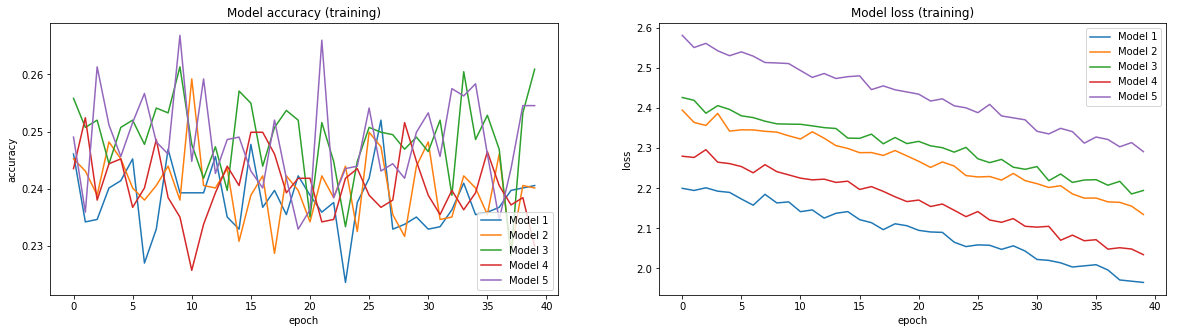

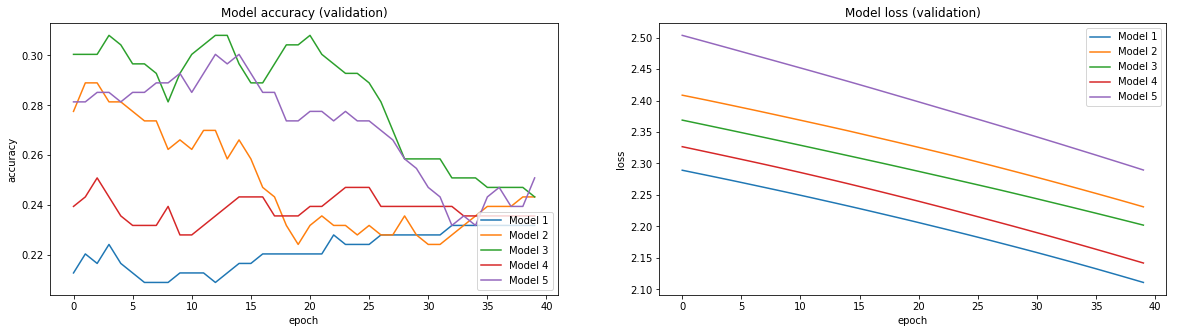

In [171]:
plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')